In [4]:
# write svm for classification using joint_angles_per_image.csv file
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load the CSV file
#df = pd.read_csv("joint_angles_and_distances_per_image.csv")
df = pd.read_csv("datasets\\hand_crafted_features_train.csv")
# Display the first few rows of the dataframe
df.head()




is_standing  is_elbow_straight  is_elbow_ninety  is_shoulder_air  \
0          0.0                0.0              0.0              0.0   
1          0.5                0.0              1.0              1.0   
2          0.0                0.0              0.0              0.0   
3          0.0                0.0              0.0              0.0   
4          0.0                1.0              0.0              0.0   

   is_shoulder_adjoining  Left Shoulder_position_x  Left Shoulder_position_y  \
0                    0.0                665.508057                804.950684   
1                    0.0                630.867432                956.674438   
2                    1.0                  0.000000                  0.000000   
3                    0.0                737.802368                988.001831   
4                    0.0                677.520142                943.057007   

   Right Shoulder_position_x  Right Shoulder_position_y  \
0                 527.564636                 722.201660   
1                 595.199951                 844.819885   
2                   0.000000                   0.000000   
3                 511.211731                1103.709229   
4                 680.474487                 889.215454   

   Left Elbow_position_x  ...  Right Hip-Right Knee_distance  \
0             689.924194  ...                     295.692230   
1             828.369507  ...                    1006.176758   
2             554.233704  ...                     228.502716   
3             918.739929  ...                     261.809296   
4             752.390381  ...                     375.177582   

   Right Hip-Left Ankle_distance  Right Hip-Right Ankle_distance  \
0                     458.102997                      366.550507   
1                    1006.176758                     1006.176758   
2                     330.362244                      388.544006   
3                     423.711060                      373.981567   
4                     218.661377                      516.164185   

   Left Knee-Right Knee_distance  Left Knee-Left Ankle_distance  \
0                     208.989395                     240.535431   
1                       0.000000                       0.000000   
2                      86.897583                     279.853516   
3                     413.173767                     250.807648   
4                     218.090225                     157.775238   

   Left Knee-Right Ankle_distance  Right Knee-Left Ankle_distance  \
0                       60.458260                      449.424255   
1                        0.000000                        0.000000   
2                      314.732910                      283.994385   
3                      478.134064                      300.248840   
4                      393.502533                      229.188934   

   Right Knee-Right Ankle_distance  Left Ankle-Right Ankle_distance  \
0                       258.109863                       200.321472   
1                         0.000000                         0.000000   
2                       297.558807                        76.299881   
3                       112.172729                       305.913971   
4                       224.437302                       304.515991   

         Label  
0  bench press  
1  bench press  
2  bench press  
3  bench press  
4  bench press  

[5 rows x 96 columns]

In [5]:
df.shape    

(9381, 96)

In [6]:

df.isnull().sum().sort_values(ascending=False)

is_standing                        0
is_elbow_straight                  0
is_elbow_ninety                    0
is_shoulder_air                    0
is_shoulder_adjoining              0
                                  ..
Left Knee-Right Ankle_distance     0
Right Knee-Left Ankle_distance     0
Right Knee-Right Ankle_distance    0
Left Ankle-Right Ankle_distance    0
Label                              0
Length: 96, dtype: int64

In [7]:
# print dropped columns 

dropped_columns = df.columns[df.isnull().sum() > 0]
print(f"Dropped columns: {dropped_columns}")

Dropped columns: Index([], dtype='object')


In [8]:
# drop nan columns
df = df.dropna(axis=1)


In [9]:
df.shape

(9381, 96)

In [10]:
df.isnull().sum().sum()

np.int64(0)

In [11]:
# print df's class distribution
print(df['Label'].value_counts())

Label
push up         1979
lat pulldown    1942
hammer curl     1906
plank           1841
bench press     1713
Name: count, dtype: int64


In [12]:
# make all label's count equal to the minimum count
# randomly select rows from each class to make the count equal to the minimum count
min_count = df['Label'].value_counts().min()
dfs = []
for label in df['Label'].unique():
    dfs.append(df[df['Label'] == label].sample(min_count))
df = pd.concat(dfs)

# print df's class distribution
print(df['Label'].value_counts())
# save the new dataframe to a new csv file
df.to_csv("joint_angles_and_distances_per_image_balanced.csv", index=False)

Label
bench press     1713
hammer curl     1713
lat pulldown    1713
plank           1713
push up         1713
Name: count, dtype: int64


In [16]:
# encode the labels using LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

# save the encoder to use it later
import joblib

joblib.dump(le, "..\\models\\label_encoder.joblib")


['..\\models\\label_encoder.joblib']

In [17]:
# Split the data into features (X) and labels (y)
X = df.drop(columns=["Label"])  # Features
y = df["Label"]  # Labels

# normalize the data except the label using standard scaler
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
X = standardScaler.fit_transform(X)
# save the standard scaler for future use
import joblib
joblib.dump(standardScaler, "..\\models/standard_scaler.joblib")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import joblib
import numpy as np
import matplotlib.pyplot as plt

# Optimize parameter grid with fewer values
param_grid = {
    'max_depth': [ 4, 5, 6],                     # Focused depths
    'learning_rate': [0.01, 0.1],           # Reasonable learning rates
    'n_estimators': [100,200],             # Balanced number of estimators
    'min_child_weight': [1,3,5],             # Focused range for child weight
    'subsample': [0.8, 1.0]                 # Key subsample values
}

# Initialize the model with GPU support
base_model = XGBClassifier(tree_method='hist', device='cuda', random_state=42, eval_metric='logloss')

# Setup GridSearchCV with fewer parameters
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,                                   # Reduce cross-validation folds
    scoring='accuracy',
    verbose=1,                              # Reduced verbosity
    n_jobs=-1                               # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save the best model
joblib.dump(best_model, "..\\models\\xgboost_best_model.joblib")

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(best_model.feature_importances_)), best_model.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [89]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
import joblib
import numpy as np
import matplotlib.pyplot as plt

# Optimize parameter grid with more values
param_grid = {
    'C': [0.1, 1, 10],                  # Expanded range for regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],     # Added 'poly' kernel
    'gamma': ['scale', 'auto', 0.01, 0.1]    # Expanded range for gamma
}

# Initialize the model
base_model = SVC()

# Setup GridSearchCV with more parameters
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,                                   # Reduce cross-validation folds
    scoring='accuracy',
    verbose=1,                              # Reduced verbosity
    n_jobs=-1                               # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save the best model
joblib.dump(best_model, "..\\models\\svm_model.joblib")

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       373
           1       1.00      1.00      1.00       335
           2       0.98      0.95      0.97       333
           3       0.97      0.98      0.97       351
           4       1.00      0.94      0.97       321

    accuracy                           0.97      1713
   macro avg       0.97      0.97      0.97      1713
weighted avg       0.97      0.97      0.97      1713

[[365   0   4   4   0]
 [  0 335   0   0   0]
 [ 14   1 317   0   1]
 [  7   0   0 344   0]
 [ 10   0   2   8 301]]


['models/svm_model.joblib']

In [90]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import joblib
import numpy as np
import matplotlib.pyplot as plt

# Optimize parameter grid with more values
param_grid = {
    'n_estimators': [100, 200],         # Number of trees in the forest
    'max_depth': [10, 20, 30],         # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],         # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],           # Minimum number of samples required to be at a leaf node
}

# Initialize the model
base_model = RandomForestClassifier(random_state=42)

# Setup GridSearchCV with more parameters
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,                                   # Reduce cross-validation folds
    scoring='accuracy',
    verbose=1,                              # Reduced verbosity
    n_jobs=-1                               # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save the best model
joblib.dump(best_model, "..\\models\\random_forest_model.joblib")



              precision    recall  f1-score   support

           0       1.00      0.99      1.00       373
           1       1.00      1.00      1.00       335
           2       0.99      1.00      1.00       333
           3       0.99      0.99      0.99       351
           4       0.99      0.99      0.99       321

    accuracy                           1.00      1713
   macro avg       1.00      1.00      1.00      1713
weighted avg       1.00      1.00      1.00      1713

[[371   0   2   0   0]
 [  0 335   0   0   0]
 [  0   0 332   0   1]
 [  0   0   0 349   2]
 [  1   0   0   2 318]]


['models/random_forest_model.joblib']

In [91]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Define a function for hyperparameter optimization

def build_model(hp):
    model = Sequential()
    
    # Input Layer
    model.add(layers.Dense(64, activation=hp.Choice('activation_input', ['relu', 'elu', 'tanh', 'leaky_relu']), input_shape=(input_shape,)))
    model.add(layers.BatchNormalization())

    # Hidden Layers
    model.add(layers.Dense(128, activation=hp.Choice('activation_1', ['relu', 'elu', 'tanh', 'leaky_relu'])))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.3, step=0.1)))

    model.add(layers.Dense(256, activation=hp.Choice('activation_2', ['relu', 'elu', 'tanh', 'leaky_relu'])))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(512, activation=hp.Choice('activation_3', ['relu', 'elu', 'tanh', 'leaky_relu'])))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.3, step=0.1)))

    model.add(layers.Dense(256, activation=hp.Choice('activation_4', ['relu', 'elu', 'tanh', 'leaky_relu'])))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(128, activation=hp.Choice('activation_5', ['relu', 'elu', 'tanh', 'leaky_relu'])))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('dropout_3', min_value=0.1, max_value=0.3, step=0.1)))

    model.add(layers.Dense(64, activation=hp.Choice('activation_6', ['relu', 'elu', 'tanh', 'leaky_relu'])))
    model.add(layers.BatchNormalization())

    # Output Layer
    model.add(layers.Dense(5, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Hyperparameter Tuning with 5-Fold Cross Validation

def tune_and_train_cv(X, y, input_shape, max_trials=5, epochs=20, batch_size=32):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_no = 1
    accuracies = []

    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        tuner = kt.Hyperband(
            build_model,
            objective='val_accuracy',
            max_epochs=epochs,
            factor=3,
            directory='my_dir',
            project_name=f'mlp_tuning_fold_{fold_no}'
        )

        # Search for best hyperparameters
        tuner.search(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=1)

        # Get the best hyperparameters
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        print(f"Best Hyperparameters for Fold {fold_no}:")
        print(best_hps.values)

        # Build and train the model with the best hyperparameters
        model = tuner.hypermodel.build(best_hps)
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)

        # Evaluate the model
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
        print(f"Fold {fold_no} - Test Accuracy: {test_acc:.4f}")
        accuracies.append(test_acc)

        # Plot Accuracy
        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label='val_accuracy')import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Define a function for hyperparameter optimization

def build_model(hp):
    model = Sequential()
    
    # Input Layer
    model.add(layers.Dense(64, activation=hp.Choice('activation_input', hp.Choice('activation_all', ['relu', 'elu', 'tanh', 'leaky_relu'])), input_shape=(input_shape,)))
    model.add(layers.BatchNormalization())

    # Hidden Layers
    model.add(layers.Dense(128, activation=hp.Choice('activation_all')))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('dropout_all', min_value=0.1, max_value=0.4, step=0.1)))

    model.add(layers.Dense(256, activation=hp.Choice('activation_all')))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(512, activation=hp.Choice('activation_all')))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('dropout_all')))

    model.add(layers.Dense(256, activation=hp.Choice('activation_all')))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(128, activation=hp.Choice('activation_all')))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('dropout_all')))

    model.add(layers.Dense(64, activation=hp.Choice('activation_all')))
    model.add(layers.BatchNormalization())

    # Output Layer
    model.add(layers.Dense(5, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Hyperparameter Tuning with 5-Fold Cross Validation

def tune_and_train_cv(X, y, input_shape, max_trials=5, epochs=20, batch_size=32):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_no = 1
    accuracies = []

    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        tuner = kt.Hyperband(
            build_model,
            objective='val_accuracy',
            max_epochs=epochs,
            factor=3,
            directory='my_dir',
            project_name=f'mlp_tuning_fold_{fold_no}'
        )

        # Search for best hyperparameters
        tuner.search(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=1)

        # Get the best hyperparameters
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        print(f"Best Hyperparameters for Fold {fold_no}:")
        print(best_hps.values)

        # Build and train the model with the best hyperparameters
        model = tuner.hypermodel.build(best_hps)
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)

        # Evaluate the model
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
        print(f"Fold {fold_no} - Test Accuracy: {test_acc:.4f}")
        accuracies.append(test_acc)

        # Plot Accuracy
        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.show()

        # Plot Loss
        plt.plot(history.history['loss'], label='loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='lower right')
        plt.show()

        fold_no += 1

    print(f"Average Accuracy across folds: {sum(accuracies)/len(accuracies):.4f}")

    return accuracies

        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.show()

        # Plot Loss
        plt.plot(history.history['loss'], label='loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='lower right')
        plt.show()

        fold_no += 1

    print(f"Average Accuracy across folds: {sum(accuracies)/len(accuracies):.4f}")

    return accuracies


Accuracy: 99.01%
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       373
           1       1.00      1.00      1.00       335
           2       0.99      0.99      0.99       333
           3       1.00      0.98      0.99       351
           4       0.99      0.98      0.99       321

    accuracy                           0.99      1713
   macro avg       0.99      0.99      0.99      1713
weighted avg       0.99      0.99      0.99      1713



['models/mlp_model.joblib']

# validation part

### load data

In [92]:
import pandas as pd
# Load the CSV file
df = pd.read_csv("hand_crafted_features_test.csv")


In [93]:
# make all label's count equal to the minimum count
# randomly select rows from each class to make the count equal to the minimum count
min_count = df['Label'].value_counts().min()
dfs = []
for label in df['Label'].unique():
    dfs.append(df[df['Label'] == label].sample(min_count))
df = pd.concat(dfs)

# print df's class distribution
print(df['Label'].value_counts())
# save the new dataframe to a new csv file
df.to_csv("validation_dataset_balanced.csv", index=False)

Label
push up         735
plank           735
lat pulldown    735
hammer curl     735
bench press     735
Name: count, dtype: int64


In [94]:
df.dropna(axis=1,inplace=True)

In [95]:
df.shape

(3675, 96)

In [96]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib

# encode the labels using LabelEncoder
# load the encoder
label_encoder = joblib.load("models/label_encoder.joblib")
df["Label"] = label_encoder.transform(df["Label"])

# Split the data into features (X) and labels (y)
#X_val = df.drop(columns=["Image", "Label"])  # Features
X_val = df.drop(columns=["Label"])  # Features
y_val = df["Label"]  # Labels

# normalize the data except the label using standard scaler
# load model
standardScaler = joblib.load("models/standard_scaler.joblib")
X_val = standardScaler.fit_transform(X_val)
# save the standard scaler for future use
import joblib
joblib.dump(standardScaler, "models/standard_scaler.joblib")




['models/standard_scaler.joblib']

In [97]:
y_val

380     4
626     4
163     4
646     4
678     4
       ..
2950    0
3188    0
3461    0
3203    0
3455    0
Name: Label, Length: 3675, dtype: int32

In [98]:
X_val.shape

(3675, 95)

### test models

In [99]:
X_val.shape

(3675, 95)

In [100]:
# test the xgboost model
model = joblib.load("models/xgboost_model.joblib")
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.30      0.28      0.29       735
           1       0.60      0.35      0.44       735
           2       0.28      0.39      0.32       735
           3       0.07      0.06      0.06       735
           4       0.45      0.50      0.48       735

    accuracy                           0.32      3675
   macro avg       0.34      0.32      0.32      3675
weighted avg       0.34      0.32      0.32      3675

[[209   6 379 112  29]
 [  0 258  52 136 289]
 [ 89  88 288 141 129]
 [317  80 294  44   0]
 [ 93   0  34 239 369]]


In [101]:
# test the svm model
model = joblib.load("models/svm_model.joblib")
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.56      0.77      0.65       735
           1       0.63      0.76      0.69       735
           2       0.40      0.34      0.37       735
           3       0.25      0.20      0.22       735
           4       0.31      0.23      0.27       735

    accuracy                           0.46      3675
   macro avg       0.43      0.46      0.44      3675
weighted avg       0.43      0.46      0.44      3675

[[565  48  83   5  34]
 [ 17 559   6   0 153]
 [ 84 164 253 180  54]
 [115  93 233 145 149]
 [226  28  58 251 172]]


In [102]:
# test the random forest model
model = joblib.load("models/random_forest_model.joblib")
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.44      0.66      0.53       735
           1       0.55      0.54      0.55       735
           2       0.36      0.38      0.37       735
           3       0.11      0.11      0.11       735
           4       0.72      0.39      0.51       735

    accuracy                           0.41      3675
   macro avg       0.44      0.41      0.41      3675
weighted avg       0.44      0.41      0.41      3675

[[483  44  99  99  10]
 [208 397   7  79  44]
 [ 19 113 277 271  55]
 [229 107 321  78   0]
 [163  56  57 173 286]]


In [103]:
# test the mlp model
model = joblib.load("models/mlp_model.joblib")
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))



              precision    recall  f1-score   support

           0       0.73      0.81      0.77       735
           1       0.65      0.95      0.77       735
           2       0.76      0.72      0.74       735
           3       0.63      0.53      0.58       735
           4       0.81      0.54      0.65       735

    accuracy                           0.71      3675
   macro avg       0.72      0.71      0.70      3675
weighted avg       0.72      0.71      0.70      3675

[[593  44  66   0  32]
 [  7 696   0   0  32]
 [116  64 529  13  13]
 [ 62 230  43 387  13]
 [ 35  33  61 210 396]]


In [110]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from tensorflow.keras.optimizers import Adam

def train_model(X_train, y_train, X_test, y_test, input_shape, epochs=30, batch_size=32, validation_split=0.2, learning_rate=0.001):
    model = tf.keras.Sequential([
        layers.Dense(256, activation='relu', input_shape=(input_shape,)),  # Input layer
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(5, activation='softmax') 
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    # use test data as validation data  with cross validation
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,            # Number of epochs
        batch_size=batch_size,    # Batch size
        verbose=0             # Show training progress
    )

    # Evaluate the model
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_acc:.4f}")

    # draw the loss and accuracy graph
    import matplotlib.pyplot as plt
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()
    


    return model, history, test_acc, test_loss


{'batch_size': 64, 'epochs': 30, 'learning_rate': 0.005}
Test Accuracy: 0.9802


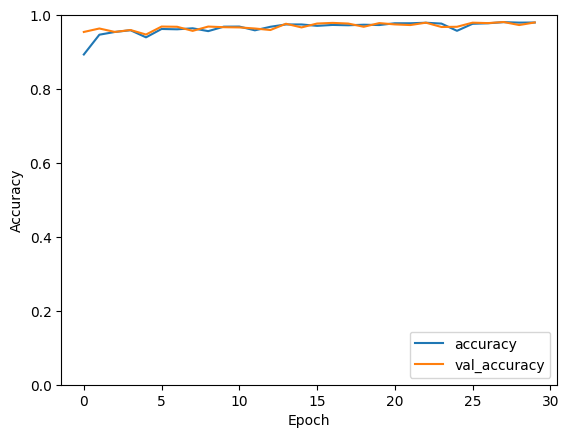

Accuracy: 0.9801517724990845, Loss: 0.22359903156757355


KeyboardInterrupt: 

In [111]:
from sklearn.model_selection import KFold

# test the mlp model with validation data
# use grid search to find the best hyperparameters
best_model = None
best_accuracy = 0
best_params = None  

from sklearn.model_selection import ParameterGrid

param_grid = {
    "epochs": [30, 50],
    "batch_size": [64, 128],
    "learning_rate": [0.005, 0.01]
}

# do cross validation with all possible hyperparameters

kf = KFold(n_splits=5, shuffle=True)

fold_accuracy = []
for params in ParameterGrid(param_grid):
    print(params)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model, history, test_acc, test_loss = train_model(X_train, y_train, X_test, y_test, X.shape[1], **params)
        fold_accuracy.append(test_acc)
        if test_acc > best_accuracy:
            best_accuracy = test_acc
            best_model = model
            best_params = params
        print(f"Accuracy: {test_acc}, Loss: {test_loss}")

print(f"Best accuracy: {best_accuracy}")
print(f"Best params: {best_params}")

        
    




In [106]:
y

1549    0
970     0
860     0
404     0
223     0
       ..
8412    4
8697    4
9354    4
7839    4
9121    4
Name: Label, Length: 8565, dtype: int32

In [107]:
# save the best model as joblib file
joblib.dump(best_model, "models/best_mlp_model.joblib")

['models/best_mlp_model.joblib']

In [115]:
# try different model architectures

def train_model(X_train, y_train, X_test, y_test, input_shape, epochs=30, batch_size=32, validation_split=0.2, learning_rate=0.001):
    model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(input_shape,)),
    layers.BatchNormalization(),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),  # Reduced dropout
    
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    
    layers.Dense(512, activation='relu'), 
    layers.BatchNormalization(),
    layers.Dropout(0.1),  # Reduced dropout

    
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),  # Reduced dropout

    
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
        
    layers.Dense(5, activation='softmax')  # Output layer
])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,            # Number of epochs
        batch_size=batch_size,    # Batch size
        verbose=0               # Show training progress
    )

    # Evaluate the model
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_acc:.4f}")

    # draw the loss and accuracy graph
    import matplotlib.pyplot as plt
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()

    # loss graph
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')
    plt.show()


    return model, history, test_acc, test_loss

{'batch_size': 32, 'epochs': 30, 'learning_rate': 0.01}
Test Accuracy: 0.6416


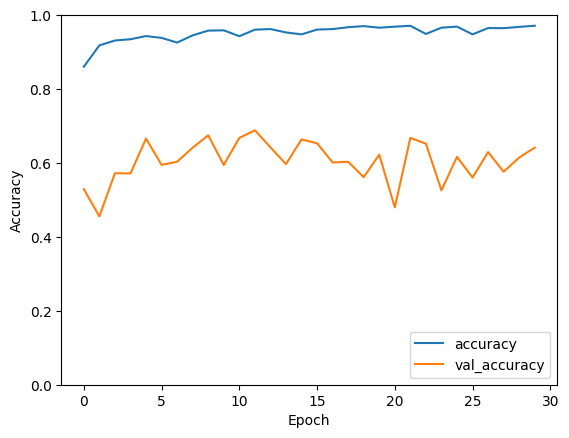

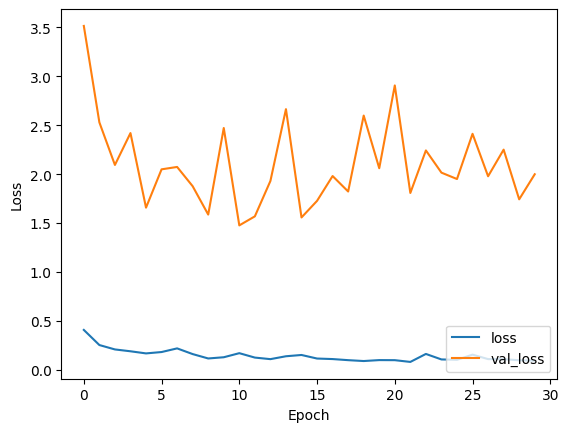

Accuracy: 0.6416326761245728, Loss: 1.9993494749069214
Test Accuracy: 0.5875


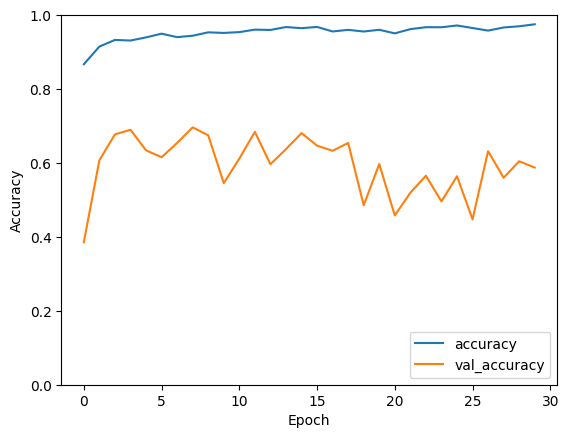

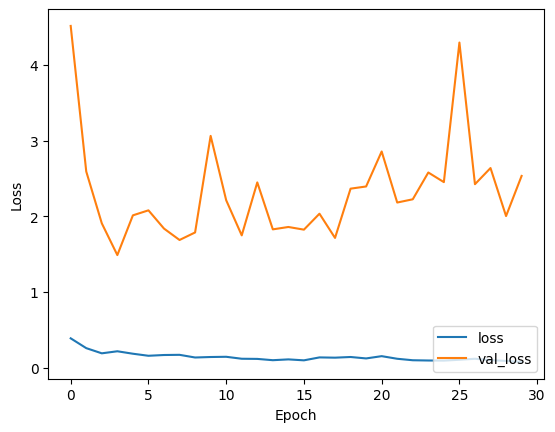

Accuracy: 0.5874829888343811, Loss: 2.53438401222229
Test Accuracy: 0.5540


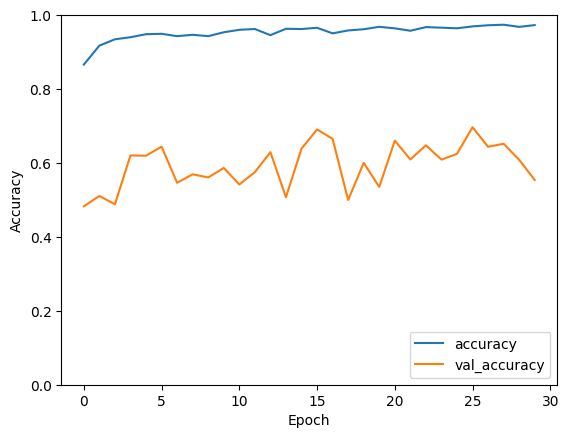

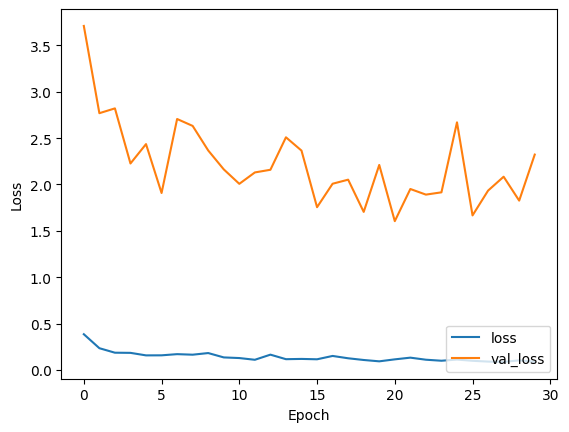

Accuracy: 0.5540136098861694, Loss: 2.3223562240600586
Test Accuracy: 0.5614


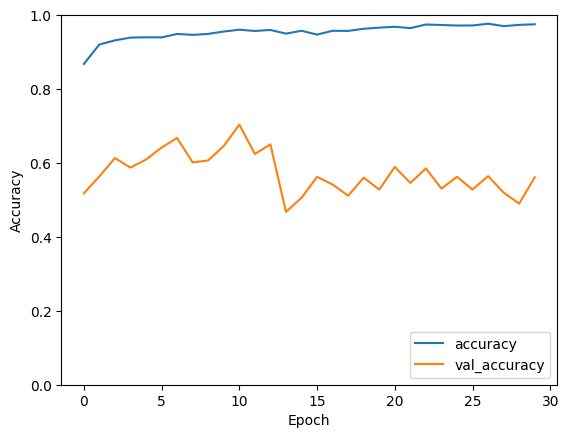

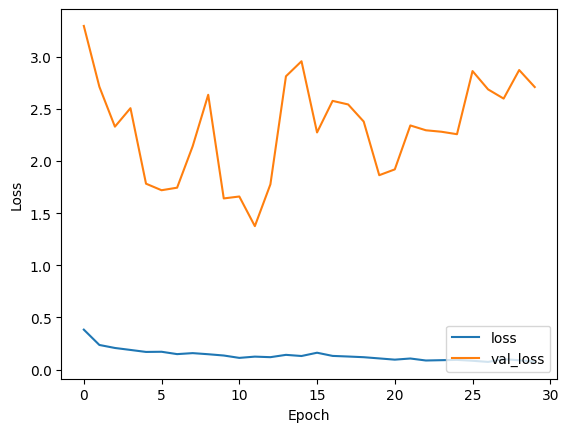

Accuracy: 0.5613605380058289, Loss: 2.7085041999816895
Test Accuracy: 0.5793


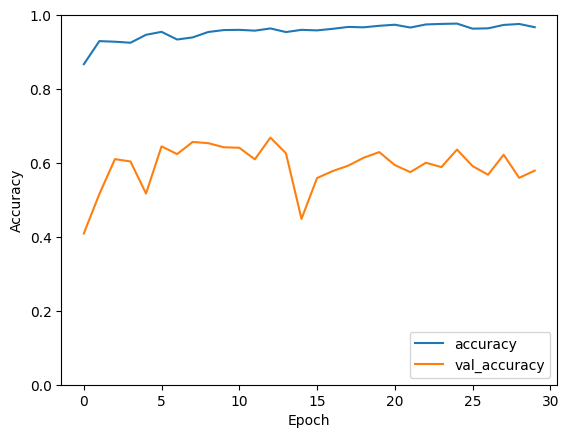

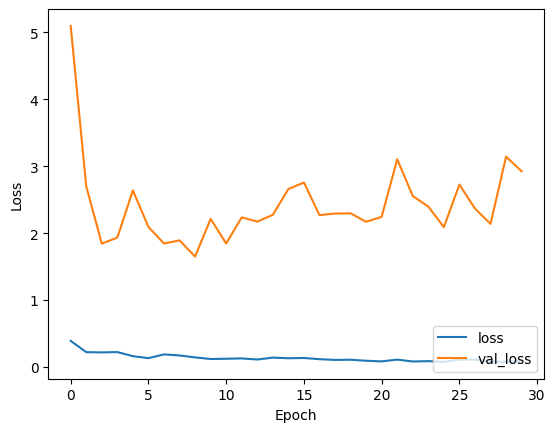

Accuracy: 0.5793197154998779, Loss: 2.9254183769226074
{'batch_size': 32, 'epochs': 30, 'learning_rate': 0.005}
Test Accuracy: 0.6212


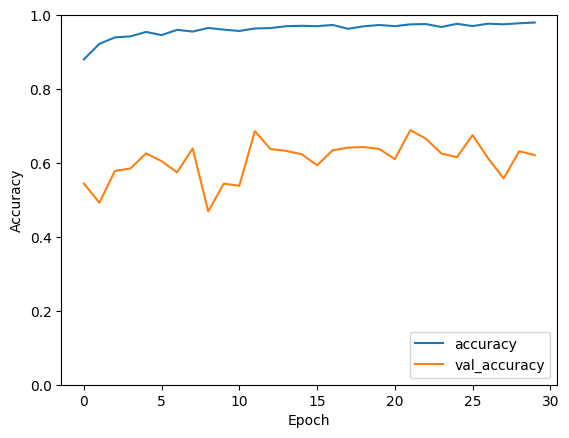

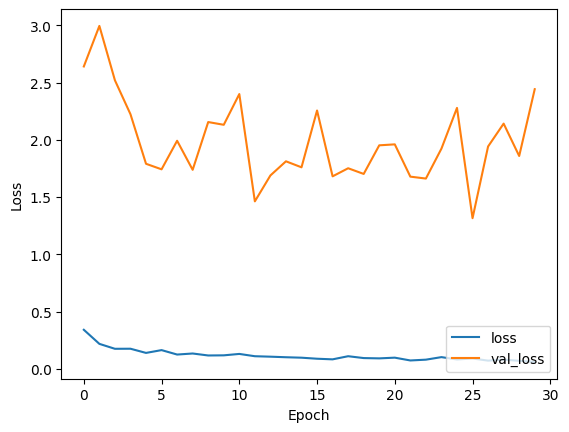

Accuracy: 0.6212244629859924, Loss: 2.441709518432617
Test Accuracy: 0.6210


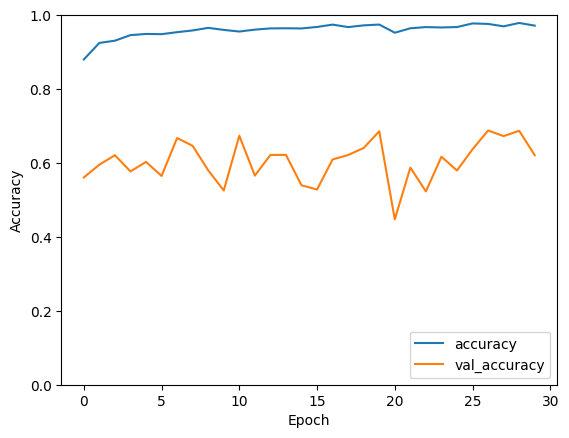

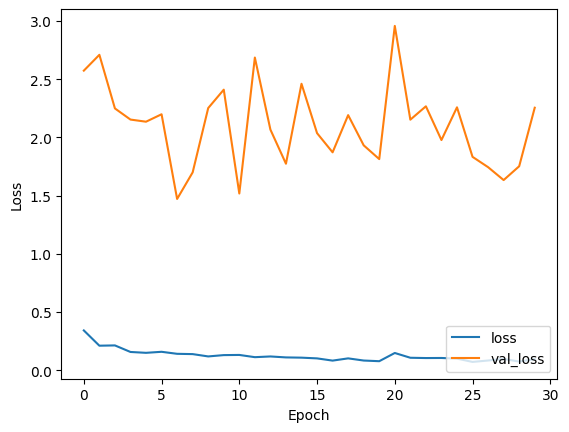

Accuracy: 0.6209523677825928, Loss: 2.254753589630127
Test Accuracy: 0.7154


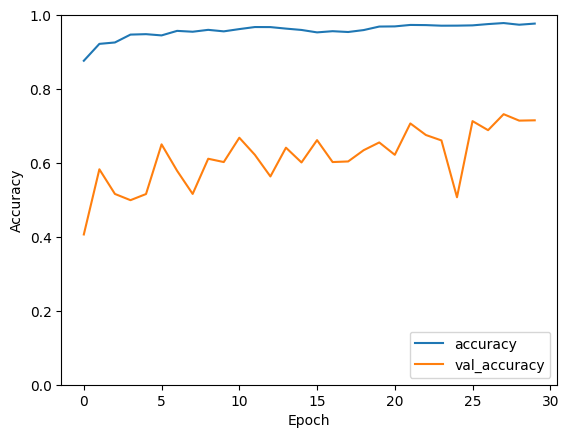

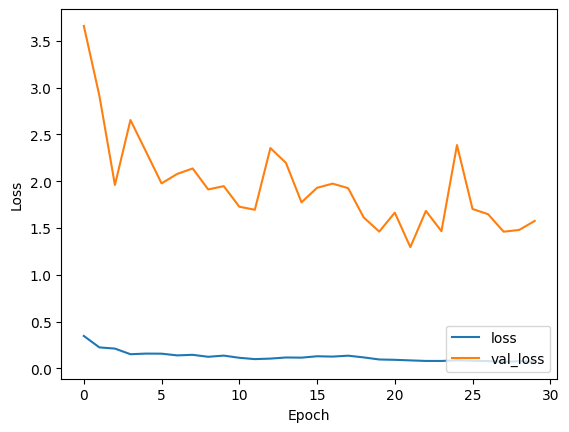

Accuracy: 0.7153741717338562, Loss: 1.5760201215744019
Test Accuracy: 0.6327


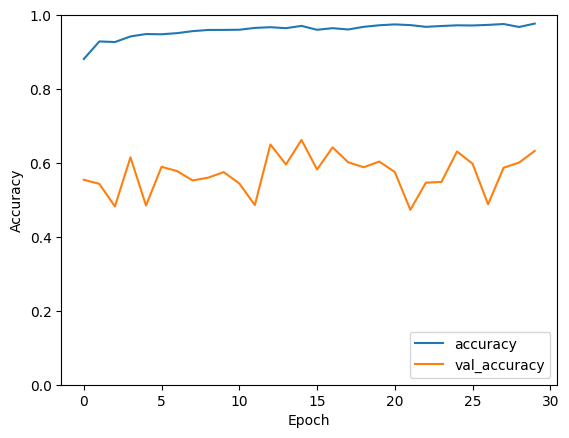

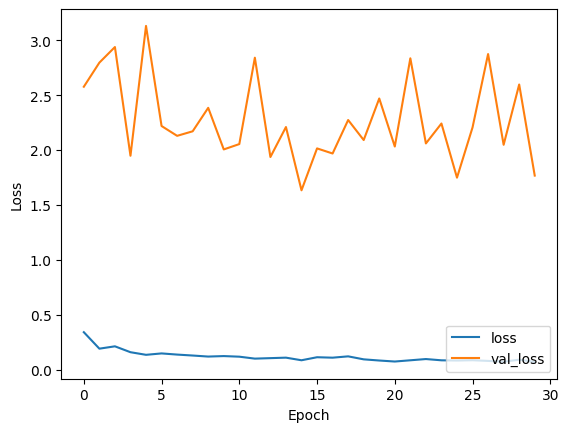

Accuracy: 0.6326530575752258, Loss: 1.768161416053772
Test Accuracy: 0.5940


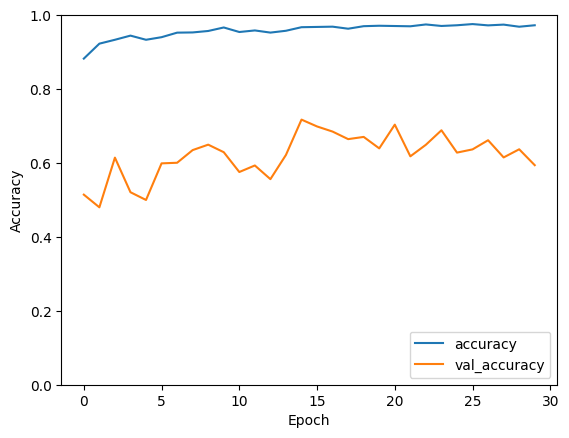

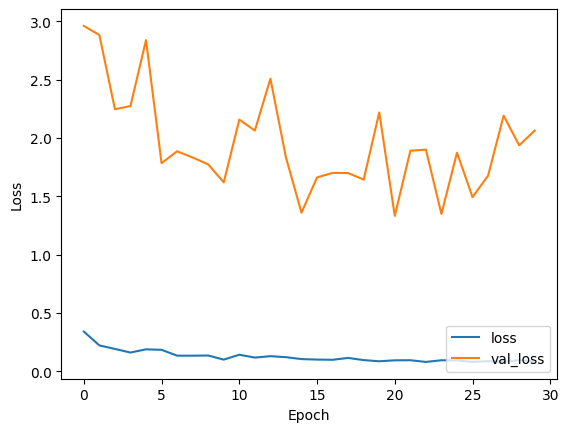

Accuracy: 0.5940136313438416, Loss: 2.063326597213745
{'batch_size': 32, 'epochs': 50, 'learning_rate': 0.01}
Test Accuracy: 0.6405


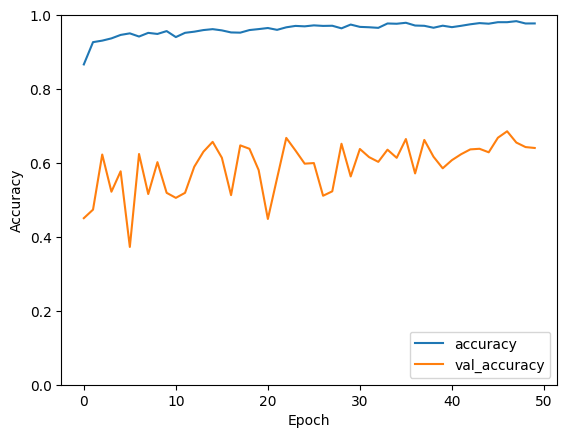

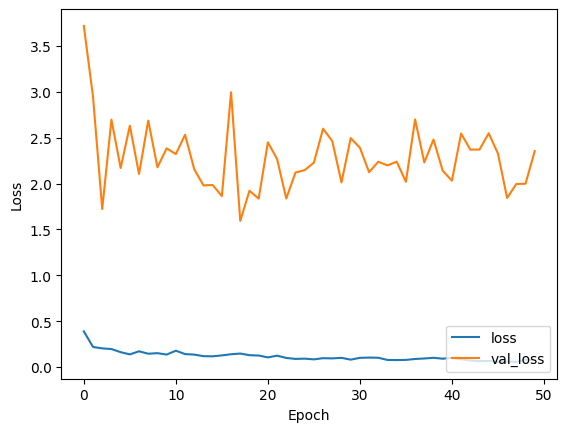

Accuracy: 0.6405442357063293, Loss: 2.3555479049682617
Test Accuracy: 0.7056


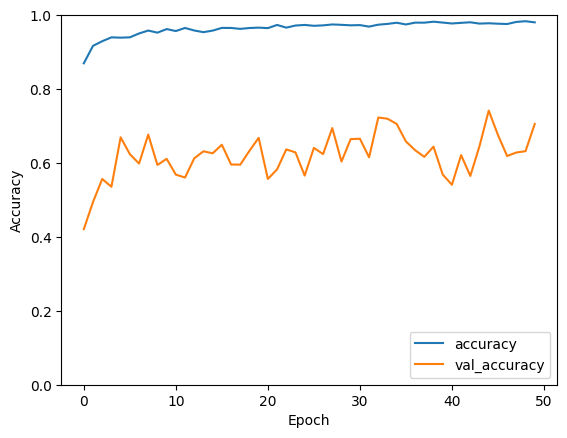

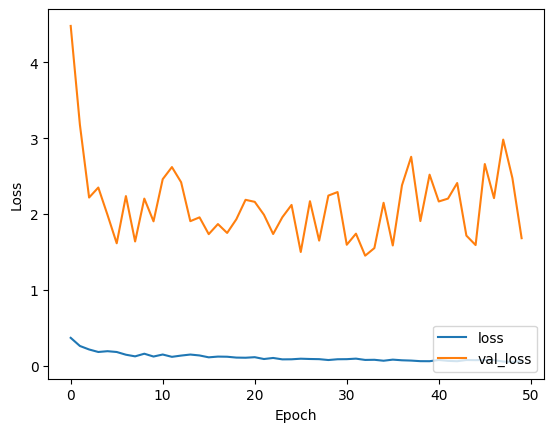

Accuracy: 0.7055782079696655, Loss: 1.6812559366226196
Test Accuracy: 0.5709


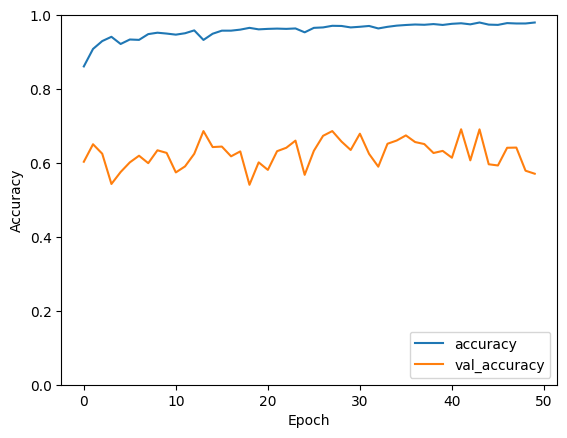

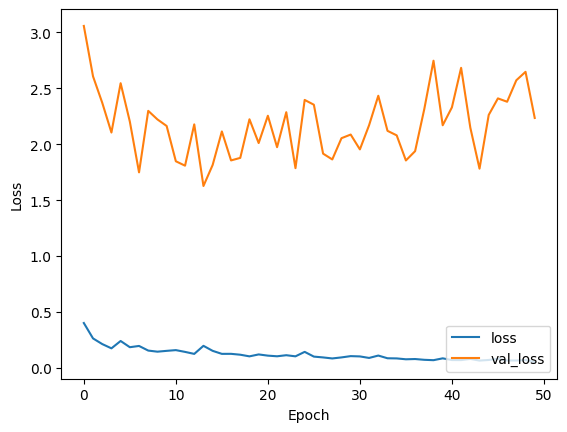

Accuracy: 0.5708843469619751, Loss: 2.234720230102539
Test Accuracy: 0.6427


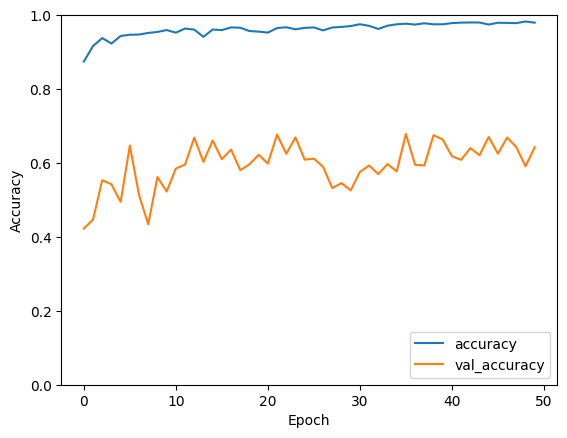

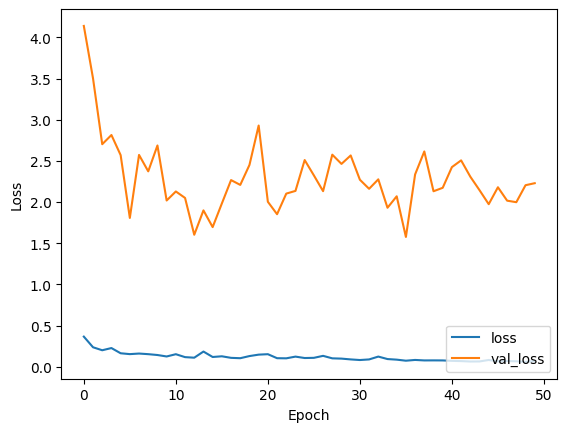

Accuracy: 0.6427211165428162, Loss: 2.2290918827056885
Test Accuracy: 0.6316


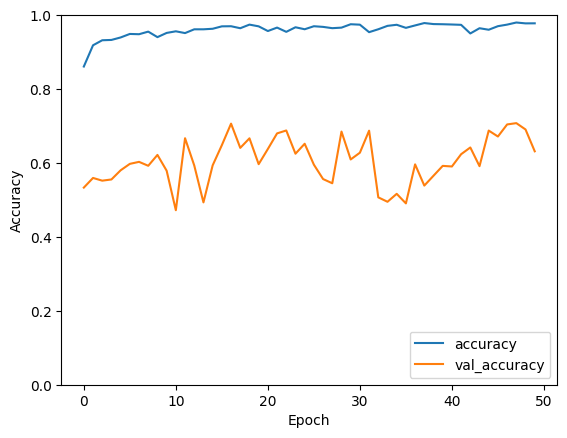

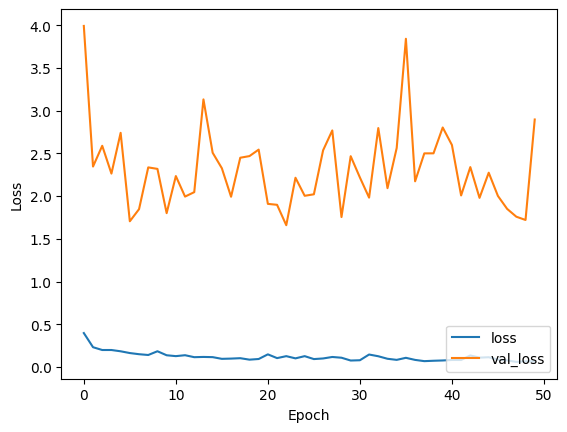

Accuracy: 0.6315646171569824, Loss: 2.8966517448425293
{'batch_size': 32, 'epochs': 50, 'learning_rate': 0.005}
Test Accuracy: 0.6302


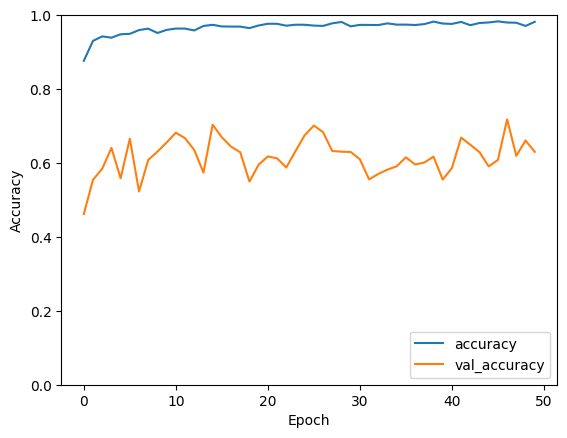

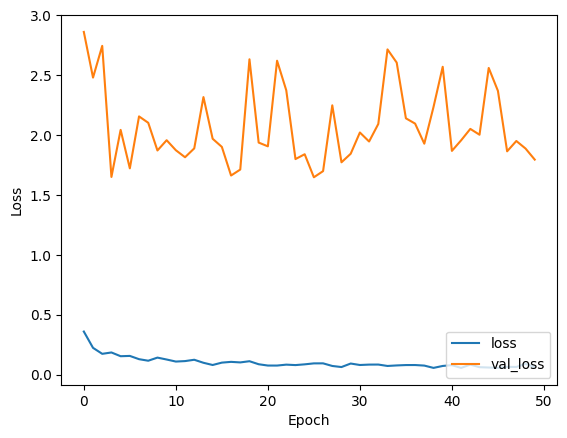

Accuracy: 0.6302040815353394, Loss: 1.7953346967697144
Test Accuracy: 0.6933


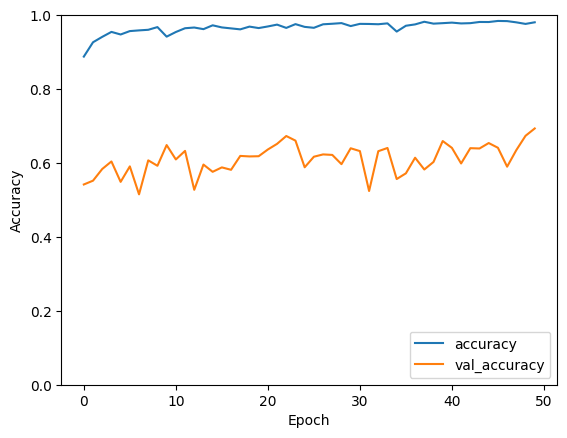

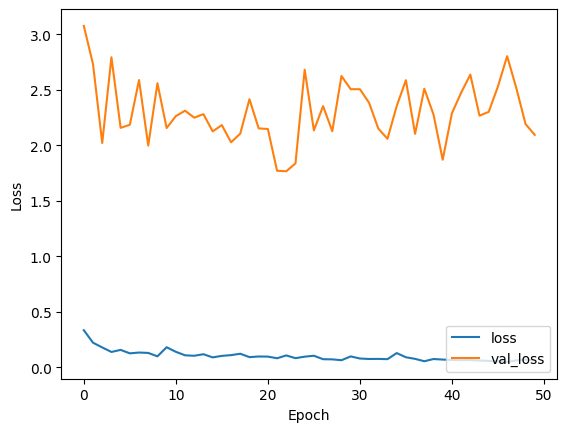

Accuracy: 0.6933333277702332, Loss: 2.0948824882507324
Test Accuracy: 0.6585


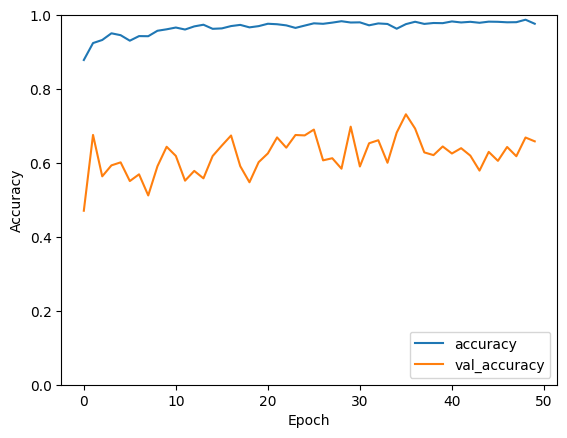

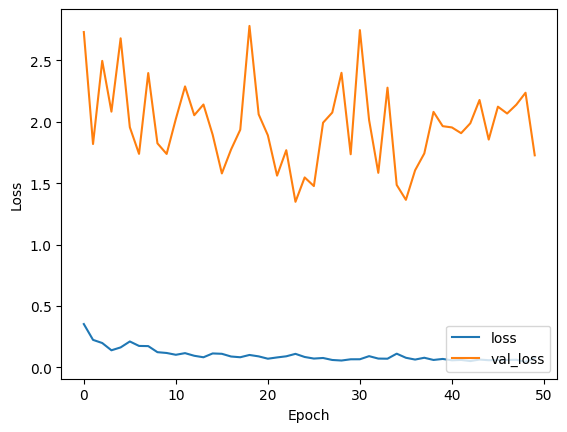

Accuracy: 0.6585034132003784, Loss: 1.7268258333206177
Test Accuracy: 0.6528


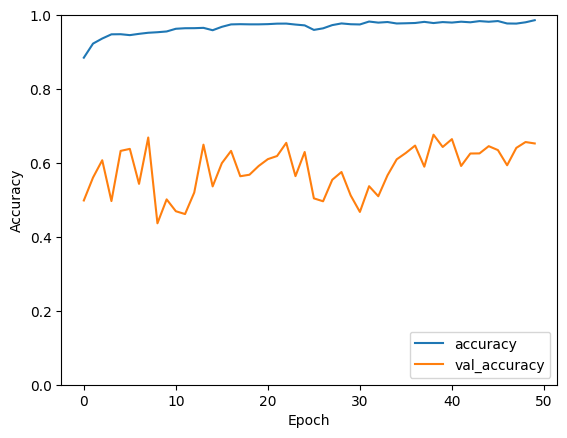

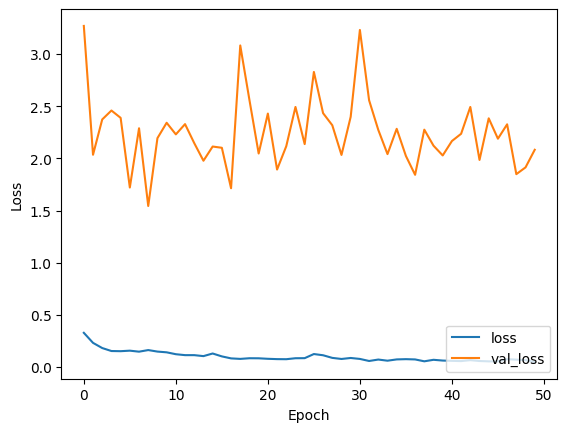

Accuracy: 0.6527891159057617, Loss: 2.082425594329834
Test Accuracy: 0.6201


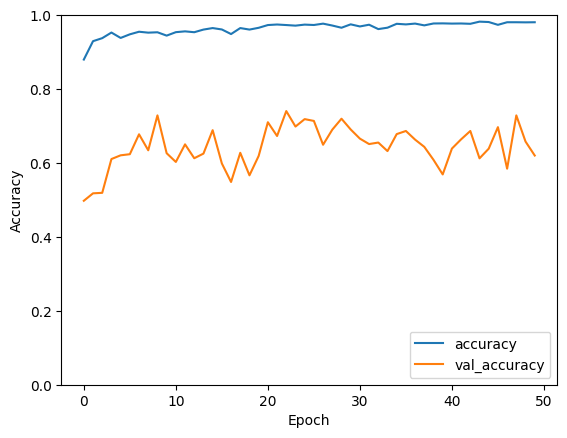

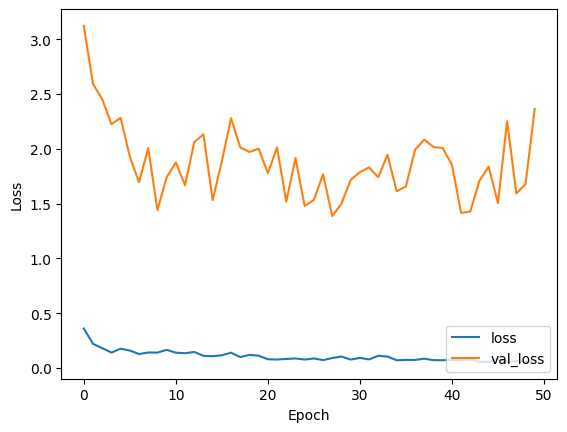

Accuracy: 0.6201360821723938, Loss: 2.3644657135009766
{'batch_size': 64, 'epochs': 30, 'learning_rate': 0.01}
Test Accuracy: 0.6008


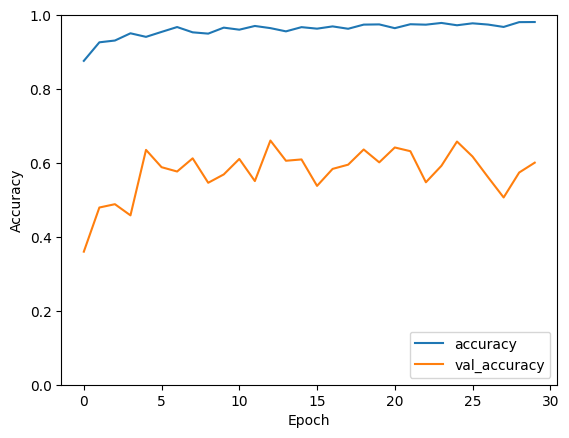

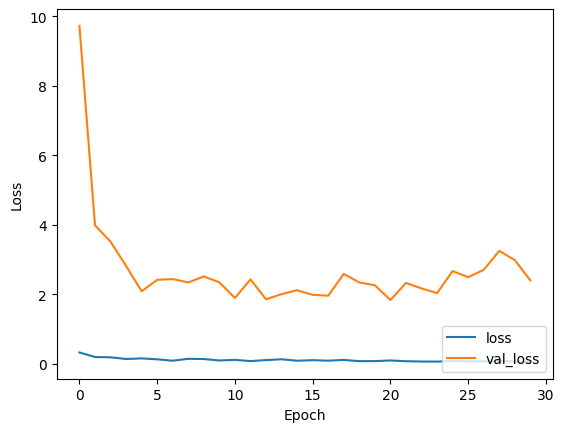

Accuracy: 0.6008163094520569, Loss: 2.4048874378204346
Test Accuracy: 0.6248


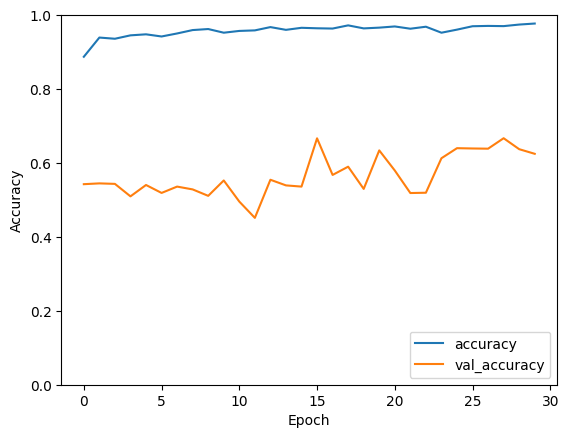

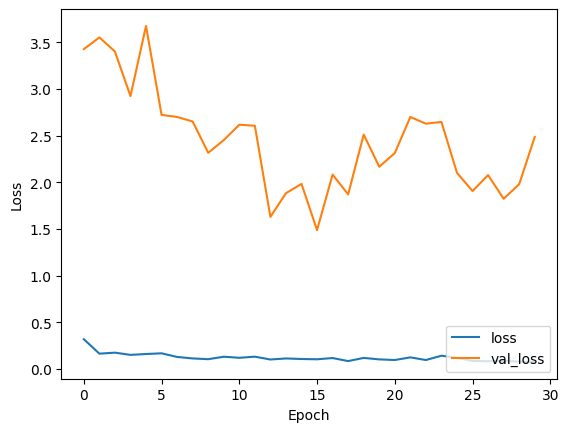

Accuracy: 0.6247618794441223, Loss: 2.4869258403778076
Test Accuracy: 0.4863


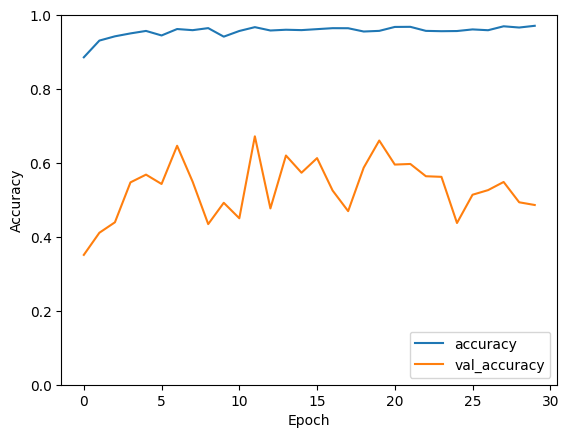

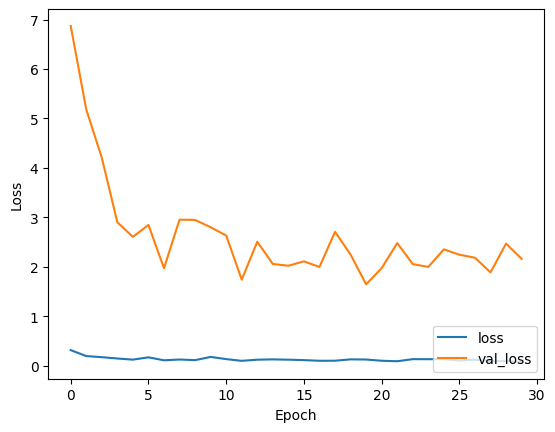

Accuracy: 0.48625850677490234, Loss: 2.161851406097412
Test Accuracy: 0.5113


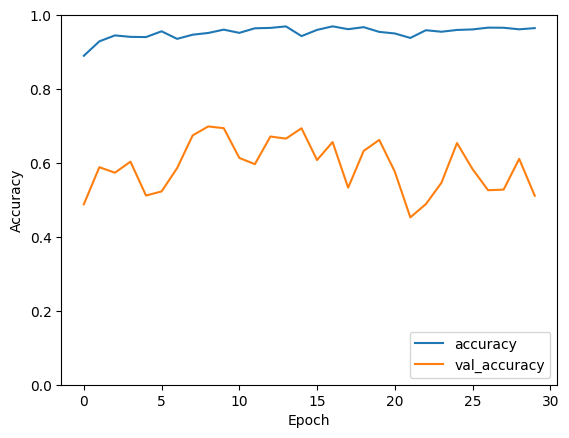

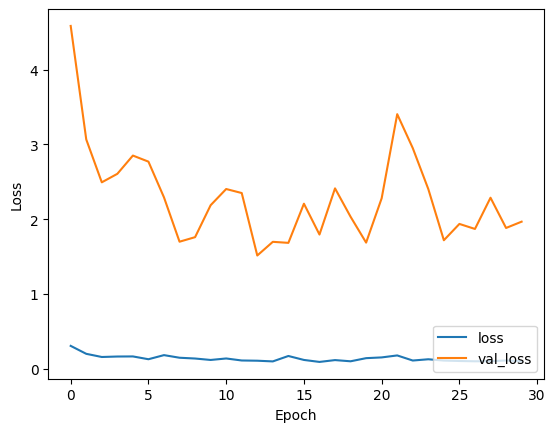

Accuracy: 0.5112925171852112, Loss: 1.9667203426361084
Test Accuracy: 0.5741


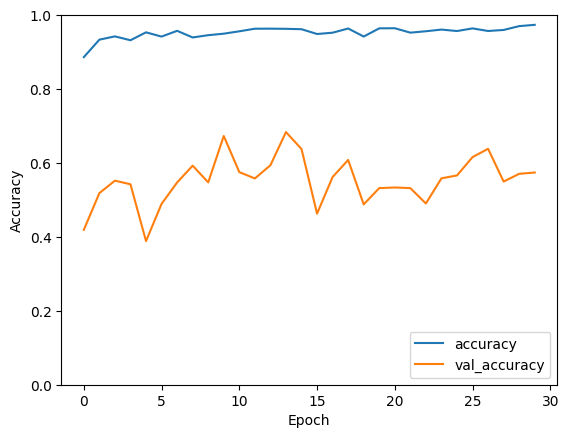

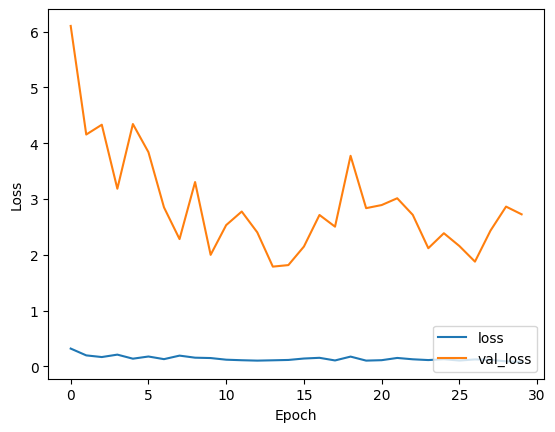

Accuracy: 0.5741496682167053, Loss: 2.7265894412994385
{'batch_size': 64, 'epochs': 30, 'learning_rate': 0.005}
Test Accuracy: 0.6582


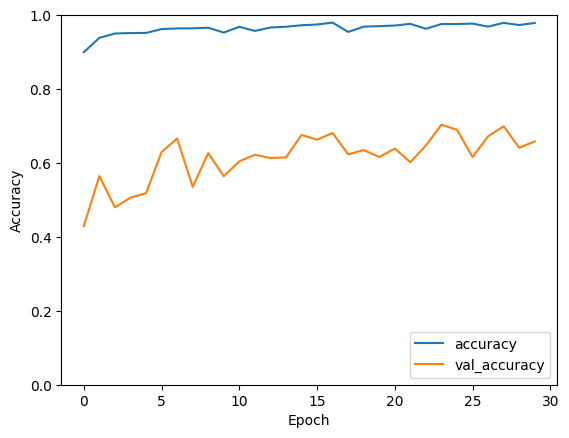

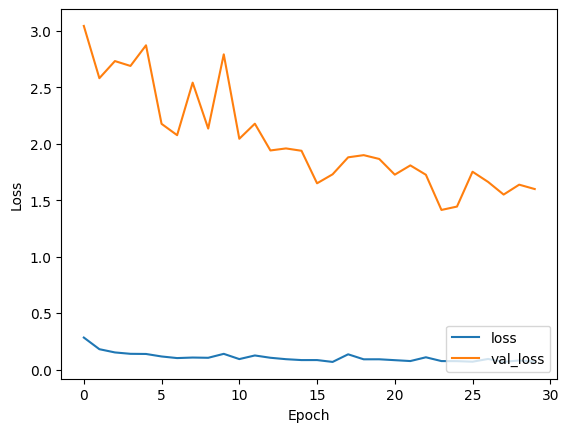

Accuracy: 0.6582313179969788, Loss: 1.5986552238464355
Test Accuracy: 0.5823


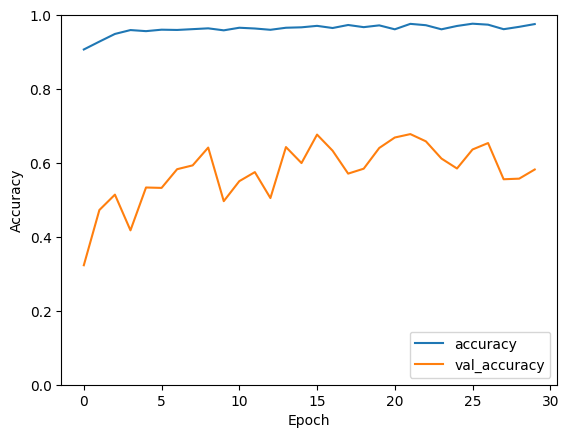

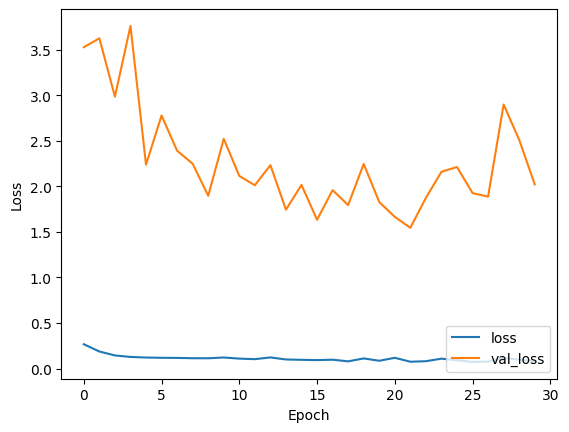

Accuracy: 0.5823129415512085, Loss: 2.0222926139831543
Test Accuracy: 0.6435


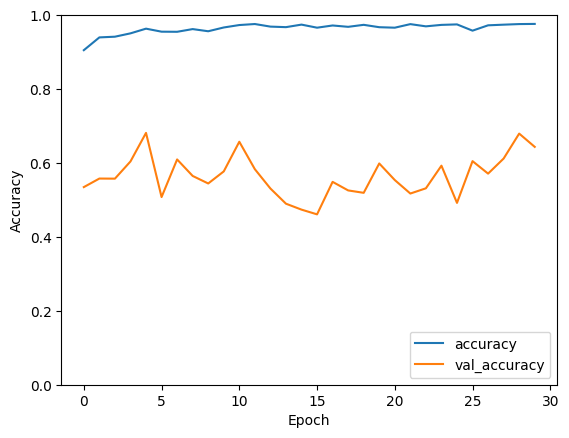

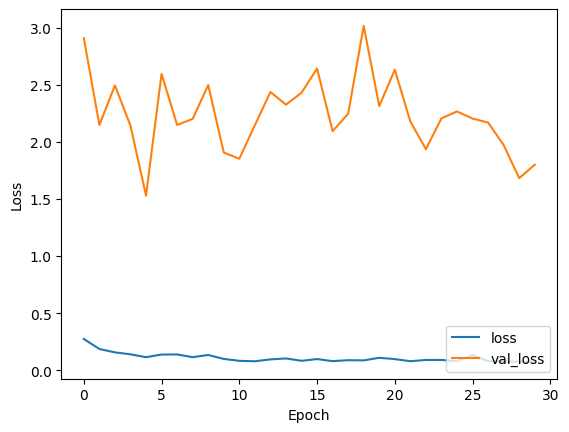

Accuracy: 0.6435374021530151, Loss: 1.8007696866989136
Test Accuracy: 0.6430


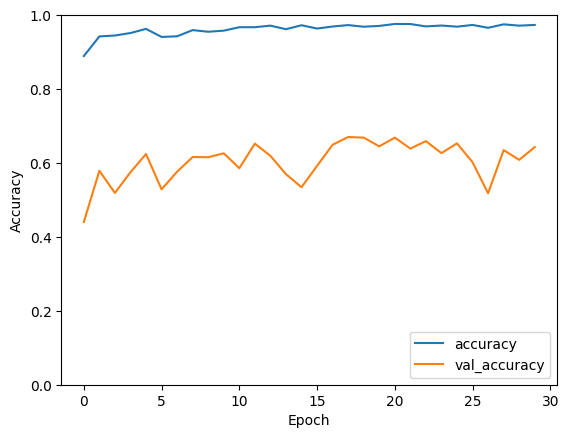

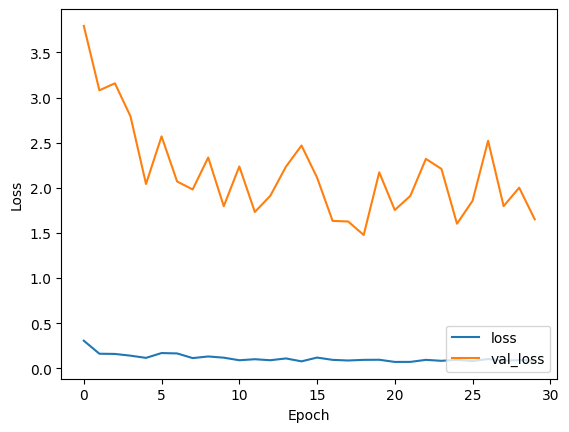

Accuracy: 0.6429932117462158, Loss: 1.6510629653930664
Test Accuracy: 0.6381


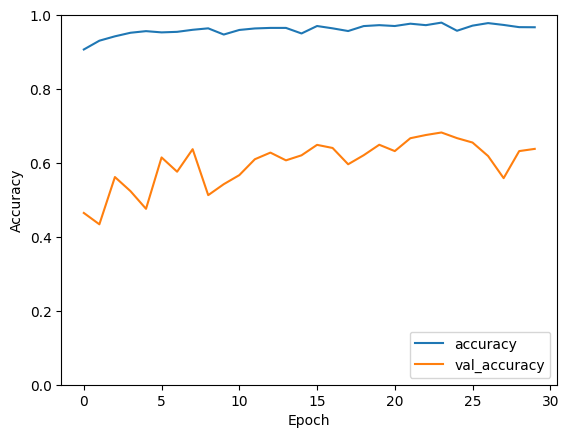

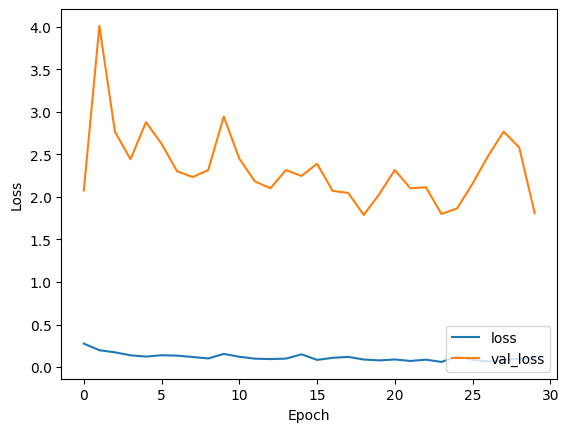

Accuracy: 0.6380952596664429, Loss: 1.8090354204177856
{'batch_size': 64, 'epochs': 50, 'learning_rate': 0.01}
Test Accuracy: 0.5875


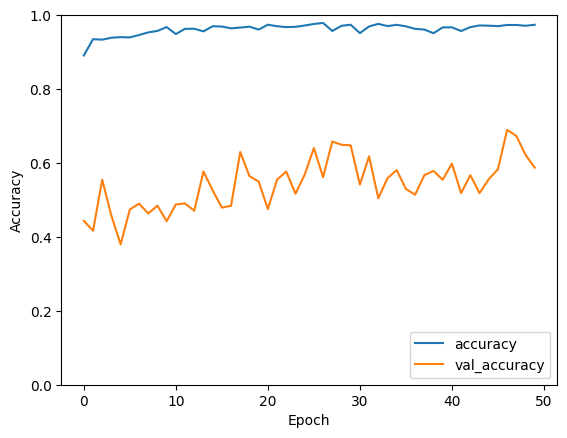

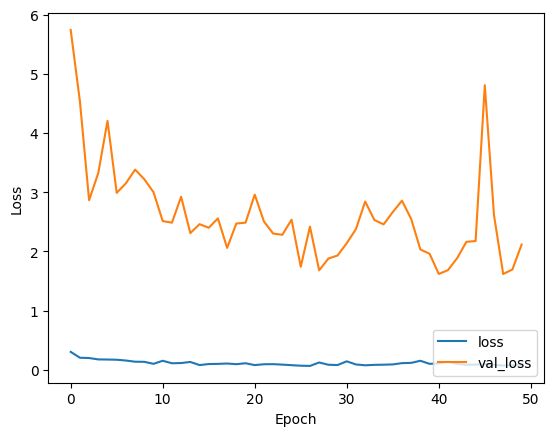

Accuracy: 0.5874829888343811, Loss: 2.1163079738616943
Test Accuracy: 0.5997


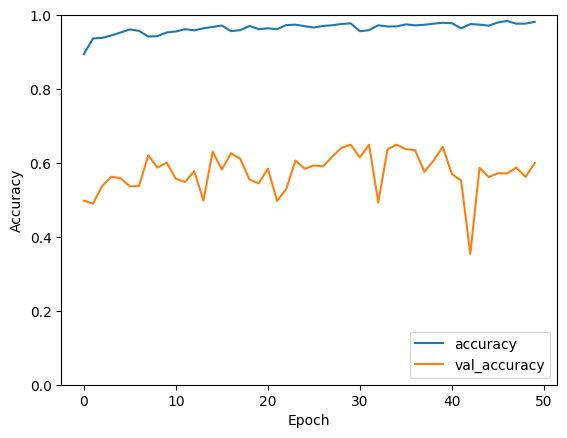

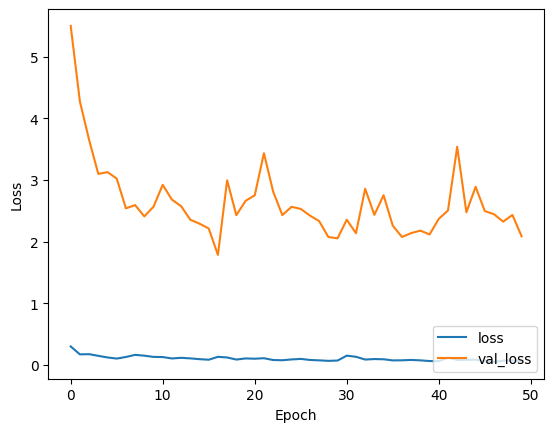

Accuracy: 0.5997278690338135, Loss: 2.087592840194702
Test Accuracy: 0.5883


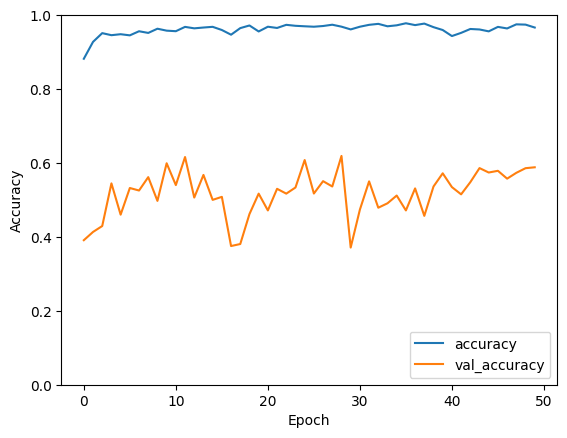

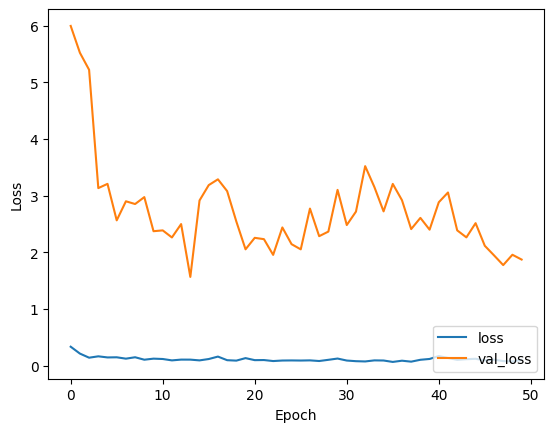

Accuracy: 0.5882993340492249, Loss: 1.872721791267395
Test Accuracy: 0.6577


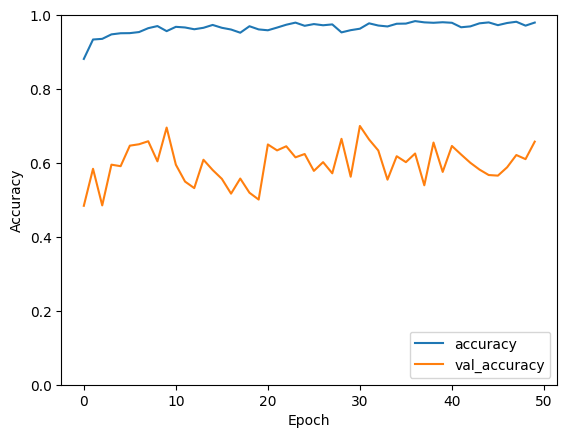

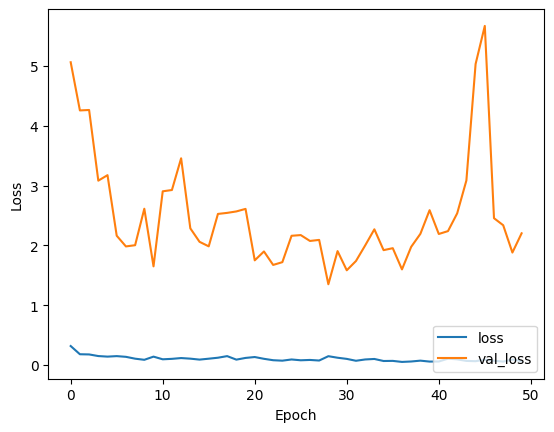

Accuracy: 0.6576870679855347, Loss: 2.2030885219573975
Test Accuracy: 0.6525


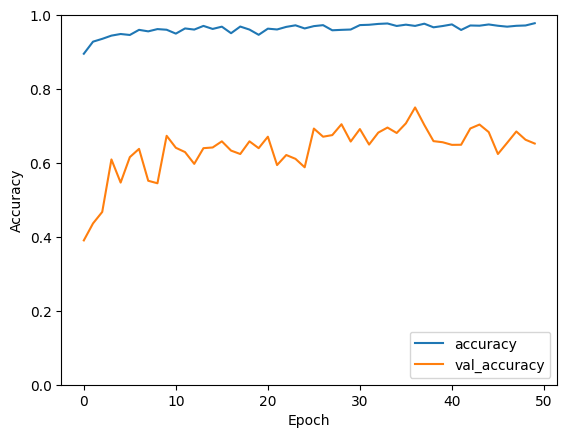

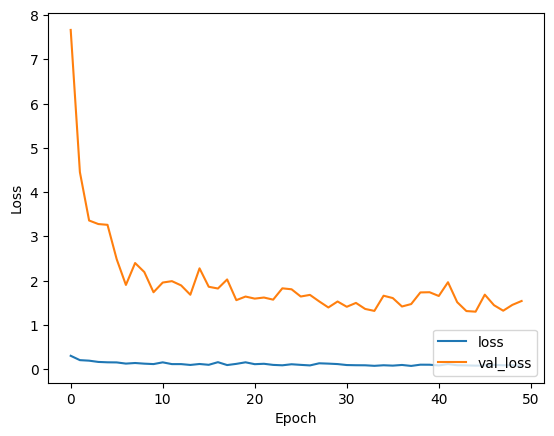

Accuracy: 0.6525170207023621, Loss: 1.5398138761520386
{'batch_size': 64, 'epochs': 50, 'learning_rate': 0.005}
Test Accuracy: 0.7056


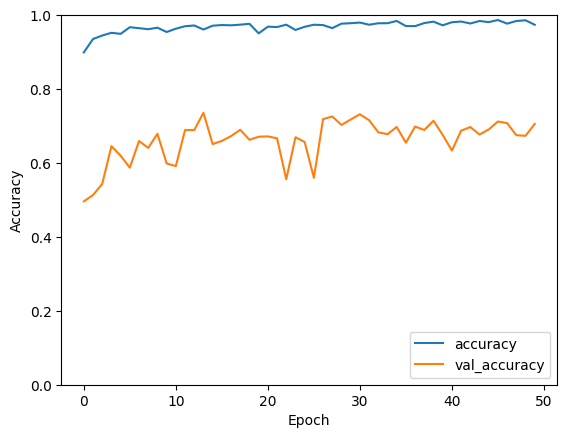

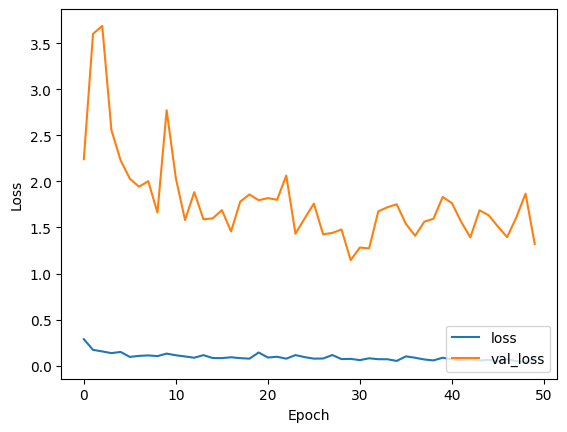

Accuracy: 0.7055782079696655, Loss: 1.321197748184204
Test Accuracy: 0.6873


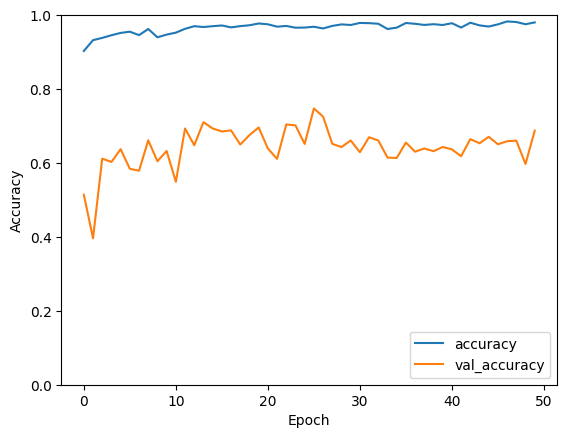

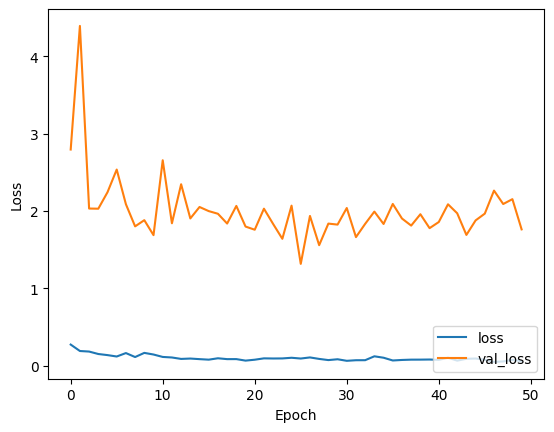

Accuracy: 0.6873469352722168, Loss: 1.7627081871032715
Test Accuracy: 0.7404


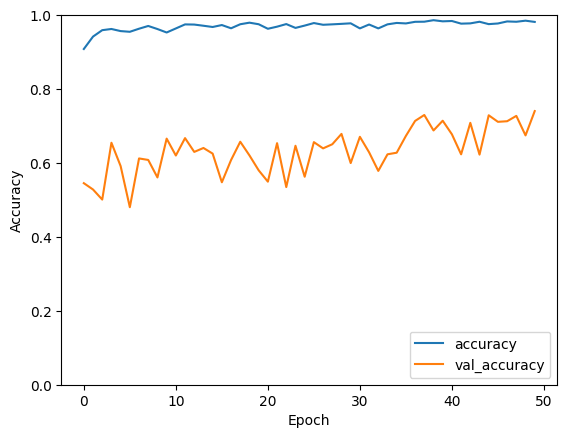

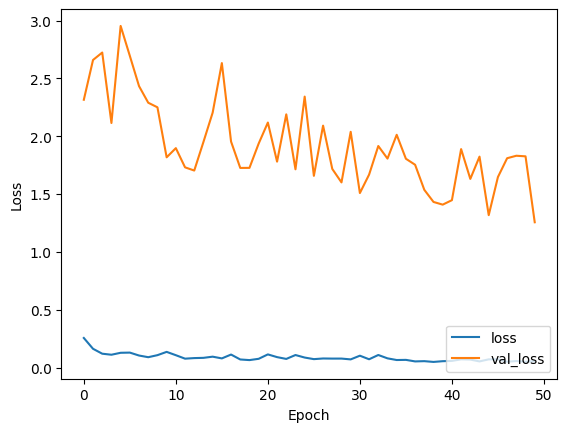

Accuracy: 0.740408182144165, Loss: 1.2565325498580933
Test Accuracy: 0.6754


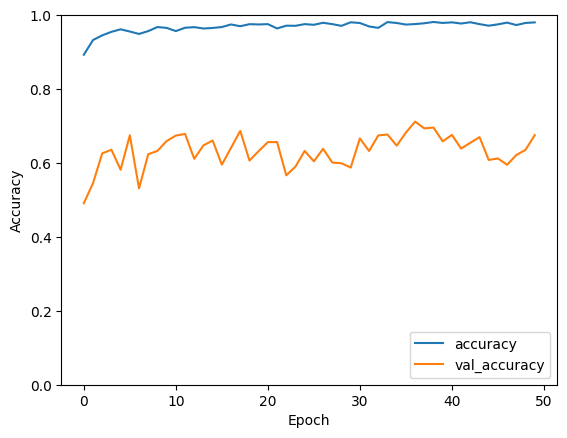

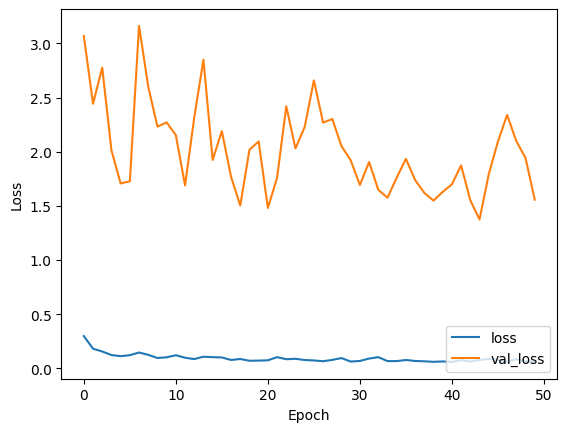

Accuracy: 0.6753741502761841, Loss: 1.557459831237793
Test Accuracy: 0.5897


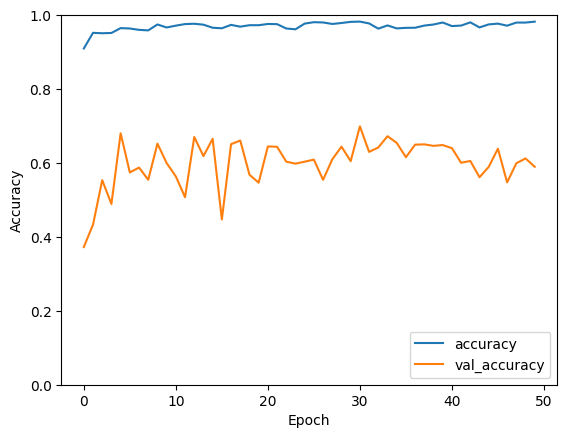

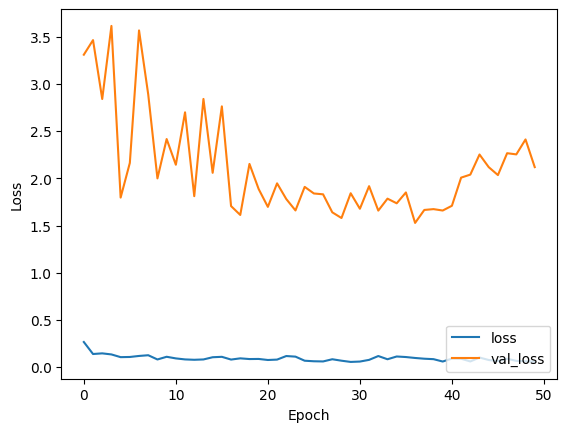

Accuracy: 0.5896598696708679, Loss: 2.1185076236724854
{'batch_size': 128, 'epochs': 30, 'learning_rate': 0.01}
Test Accuracy: 0.6860


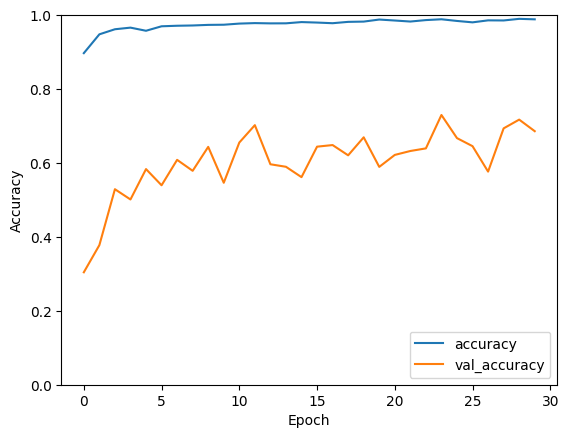

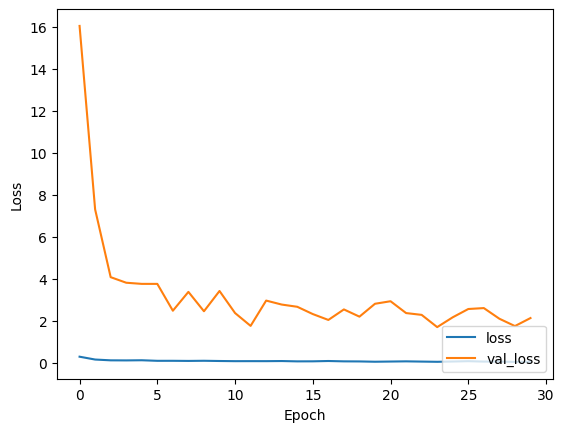

Accuracy: 0.6859863996505737, Loss: 2.1209635734558105
Test Accuracy: 0.6493


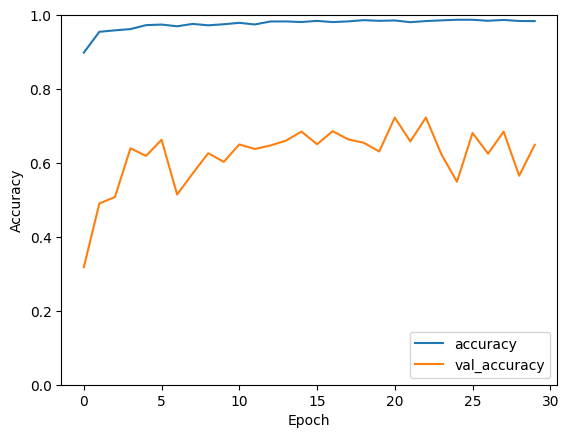

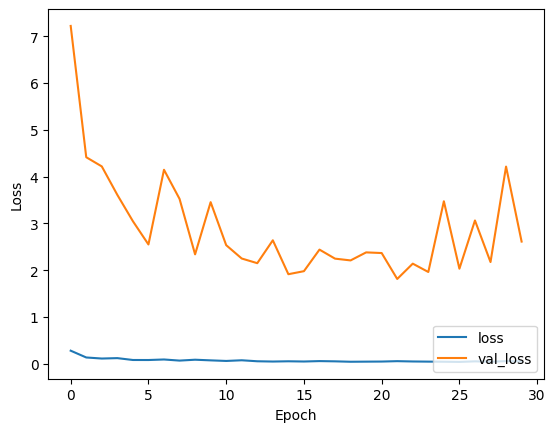

Accuracy: 0.6492516994476318, Loss: 2.6106226444244385
Test Accuracy: 0.7301


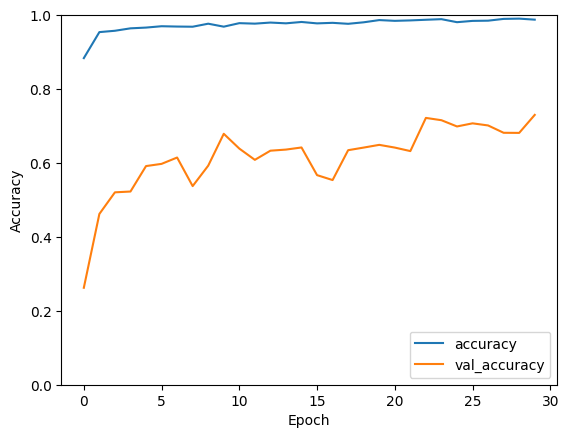

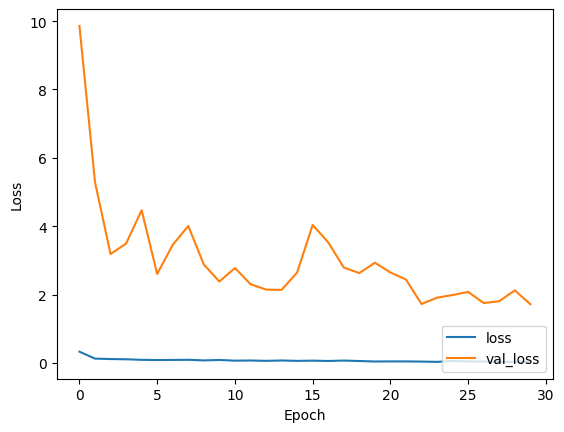

Accuracy: 0.730068027973175, Loss: 1.7179393768310547
Test Accuracy: 0.6473


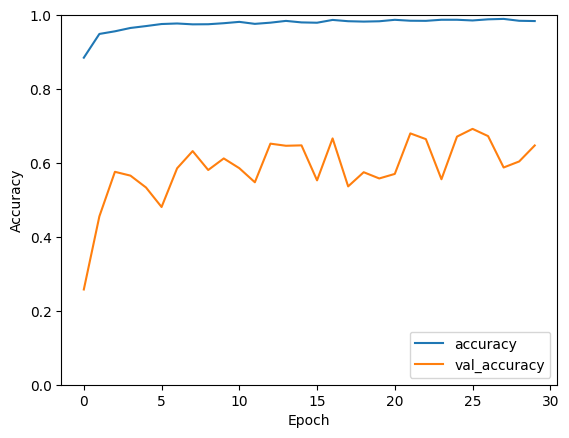

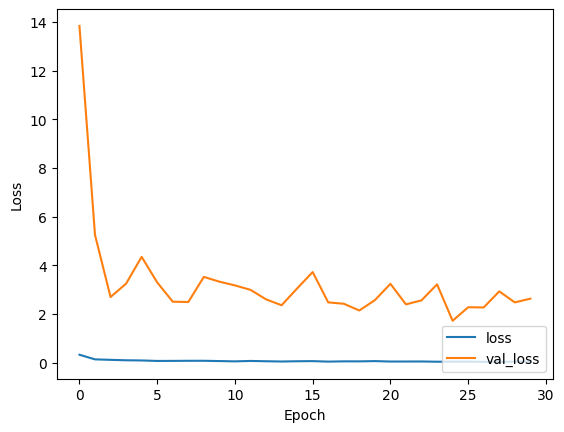

Accuracy: 0.6473469138145447, Loss: 2.6277852058410645
Test Accuracy: 0.6789


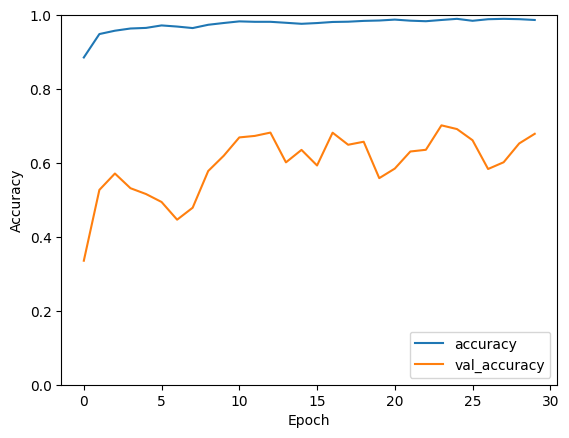

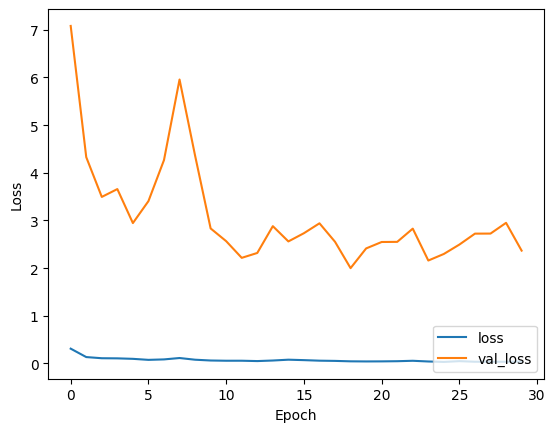

Accuracy: 0.678911566734314, Loss: 2.367356061935425
{'batch_size': 128, 'epochs': 30, 'learning_rate': 0.005}
Test Accuracy: 0.6514


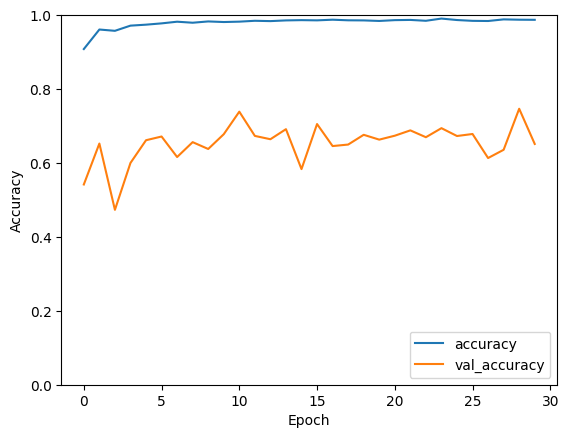

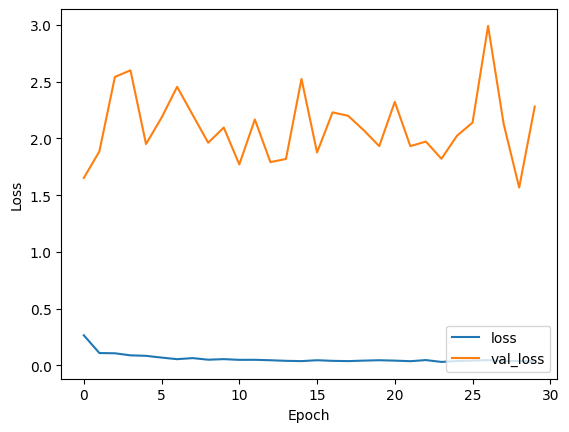

Accuracy: 0.6514285802841187, Loss: 2.2800183296203613
Test Accuracy: 0.7042


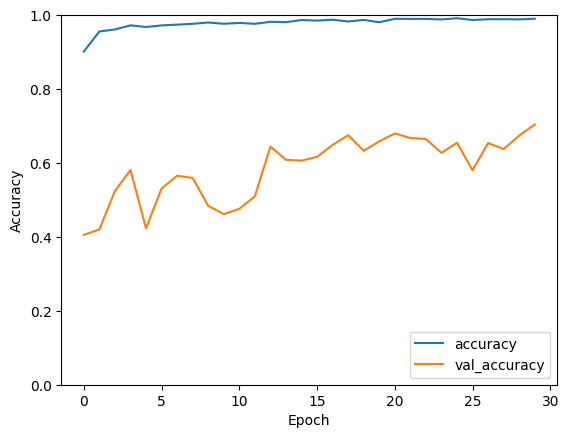

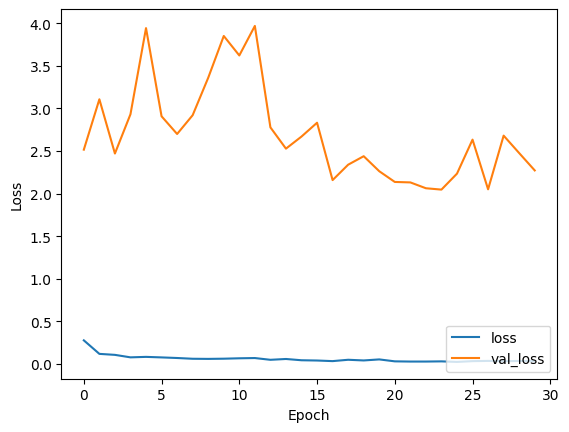

Accuracy: 0.7042176723480225, Loss: 2.2727506160736084
Test Accuracy: 0.7241


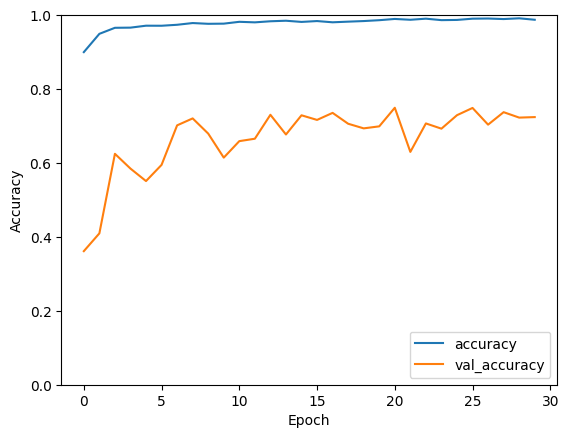

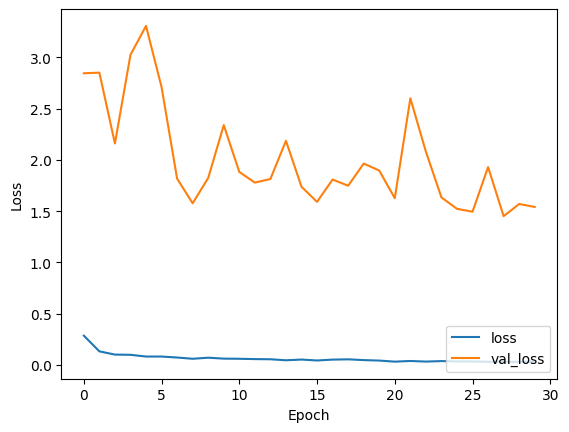

Accuracy: 0.7240816354751587, Loss: 1.5410666465759277
Test Accuracy: 0.7246


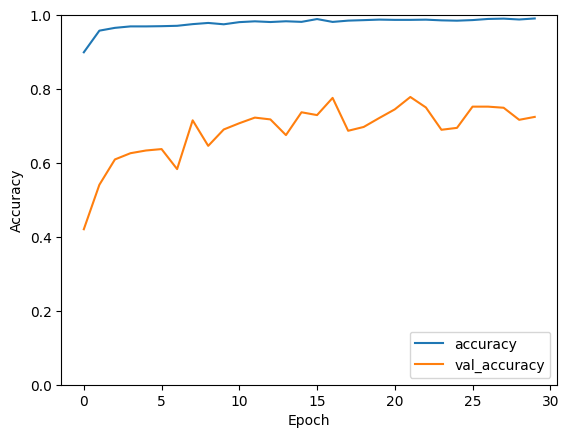

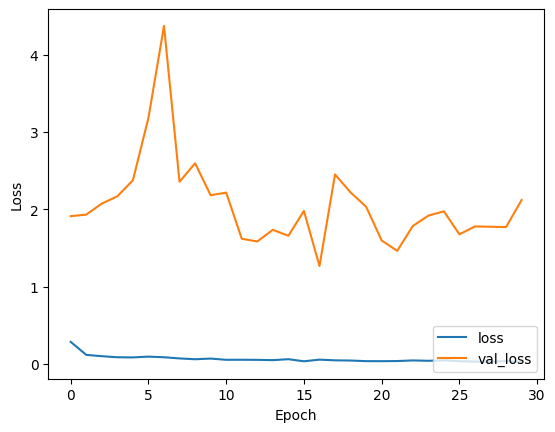

Accuracy: 0.724625825881958, Loss: 2.119844436645508
Test Accuracy: 0.6727


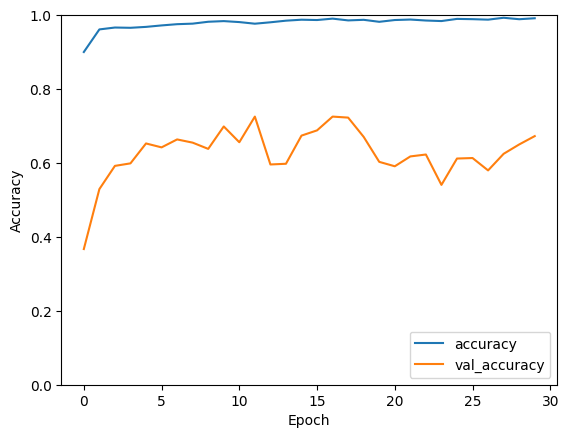

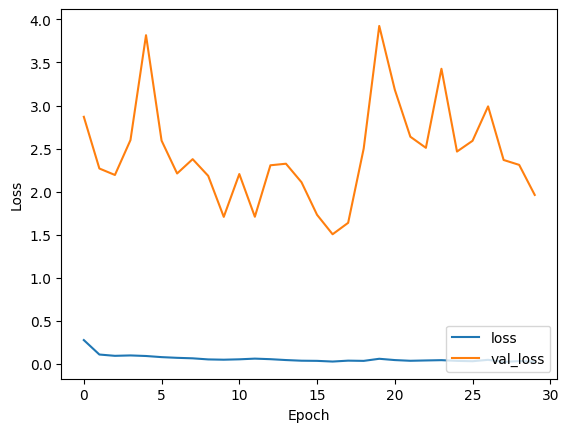

Accuracy: 0.672653079032898, Loss: 1.962207555770874
{'batch_size': 128, 'epochs': 50, 'learning_rate': 0.01}
Test Accuracy: 0.7396


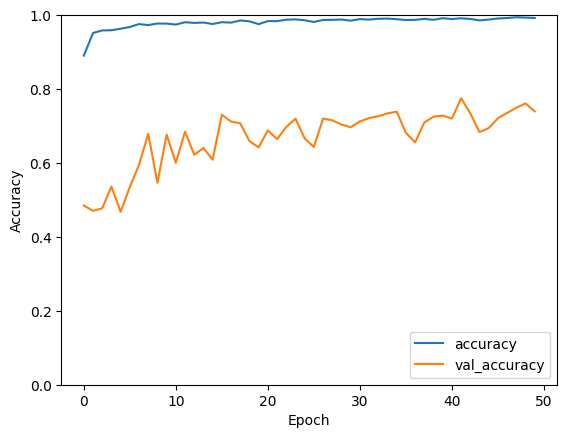

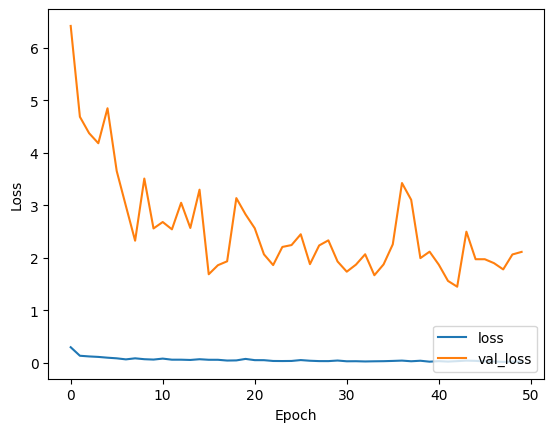

Accuracy: 0.7395918369293213, Loss: 2.112791061401367
Test Accuracy: 0.6944


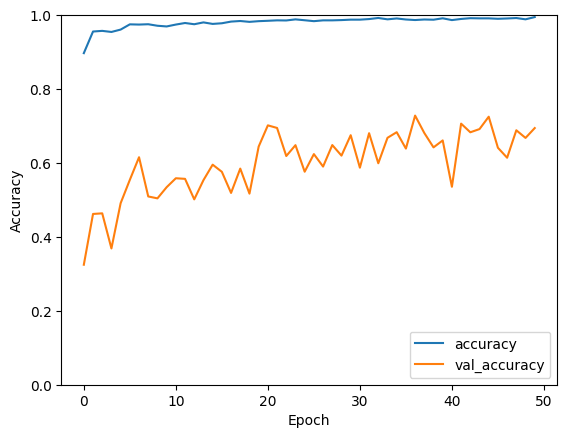

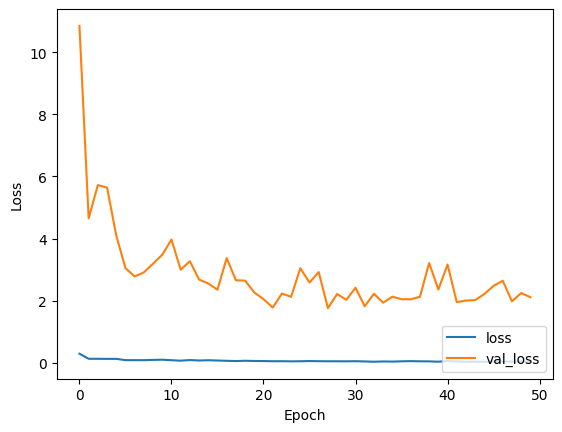

Accuracy: 0.6944217681884766, Loss: 2.1073436737060547
Test Accuracy: 0.7162


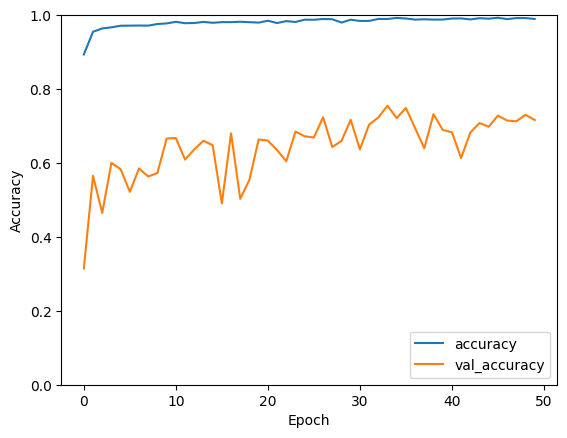

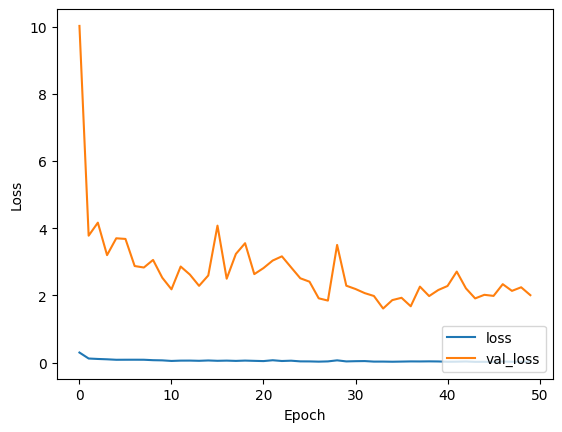

Accuracy: 0.7161904573440552, Loss: 2.0075671672821045
Test Accuracy: 0.7208


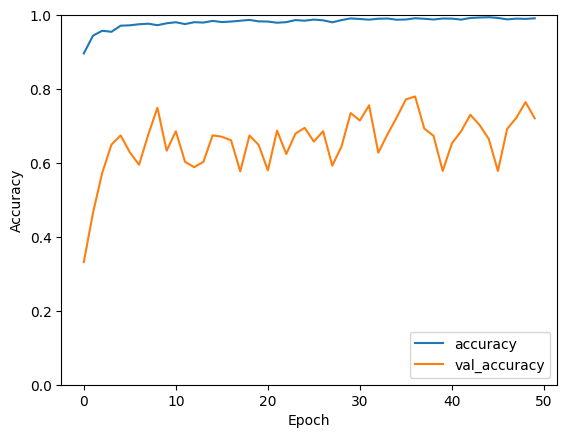

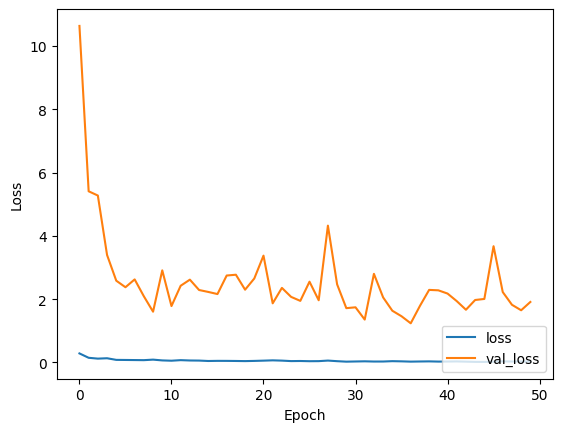

Accuracy: 0.7208163142204285, Loss: 1.9111076593399048
Test Accuracy: 0.6925


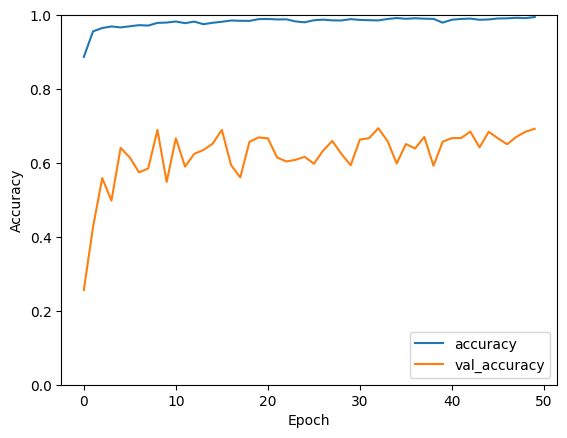

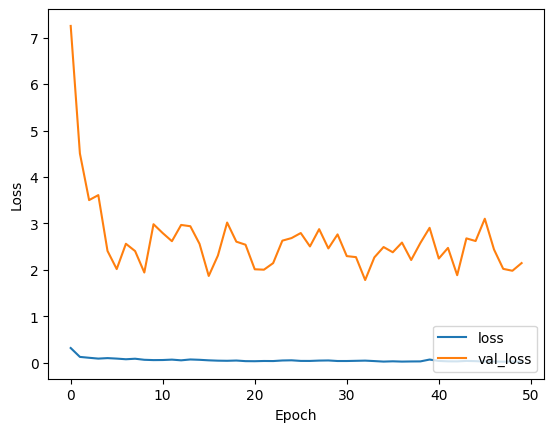

Accuracy: 0.6925169825553894, Loss: 2.1468043327331543
{'batch_size': 128, 'epochs': 50, 'learning_rate': 0.005}
Test Accuracy: 0.7771


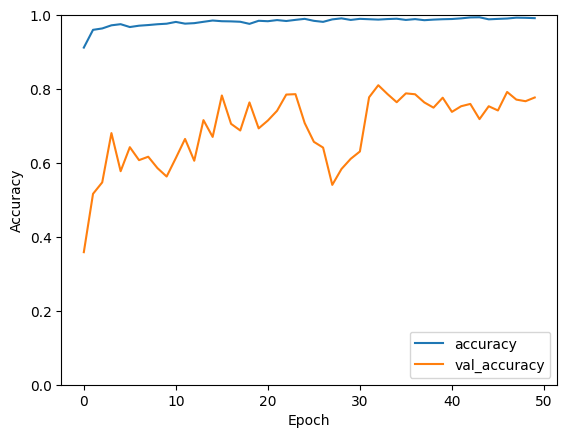

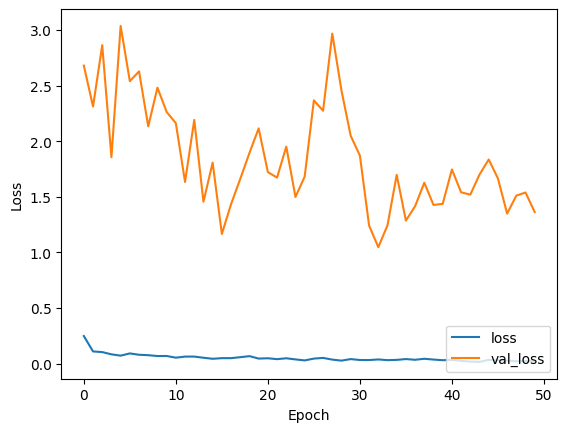

Accuracy: 0.7771428823471069, Loss: 1.363070011138916
Test Accuracy: 0.6566


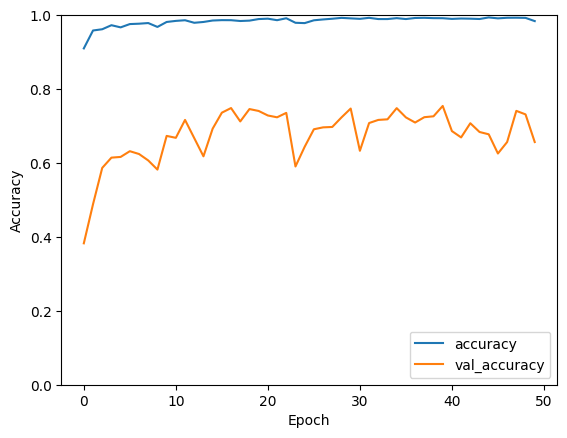

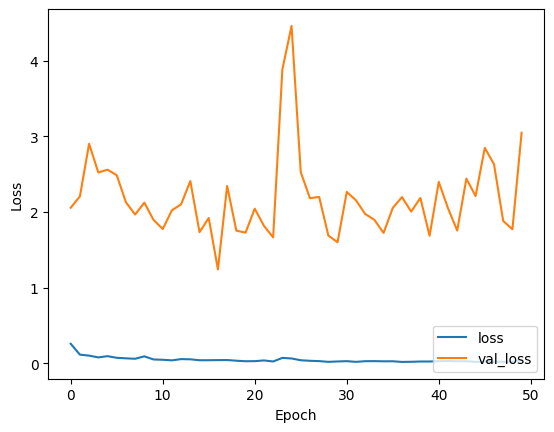

Accuracy: 0.6565986275672913, Loss: 3.0474116802215576
Test Accuracy: 0.6890


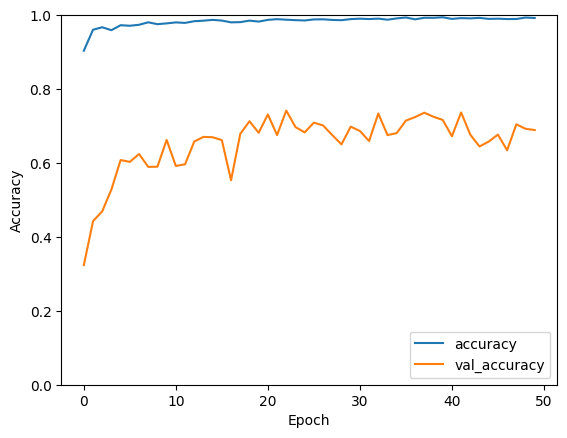

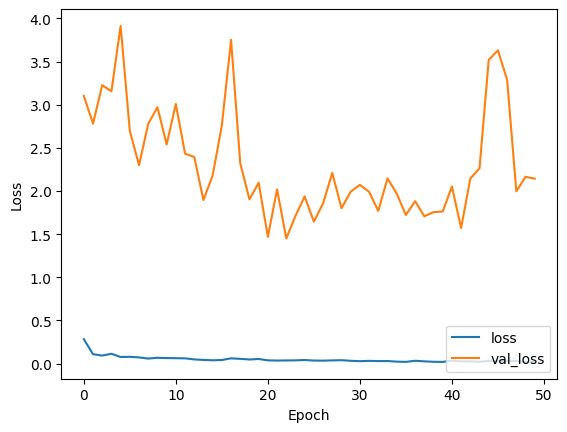

Accuracy: 0.6889795660972595, Loss: 2.1425387859344482
Test Accuracy: 0.6999


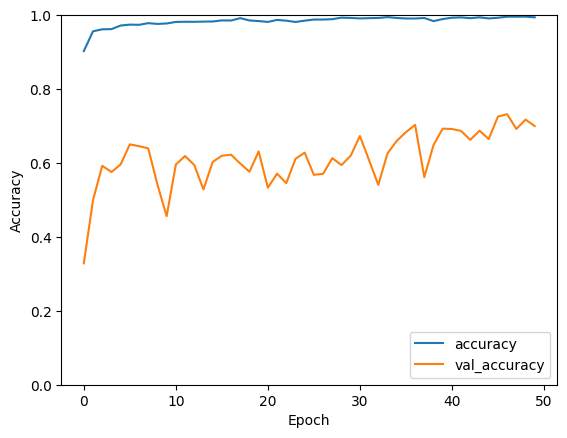

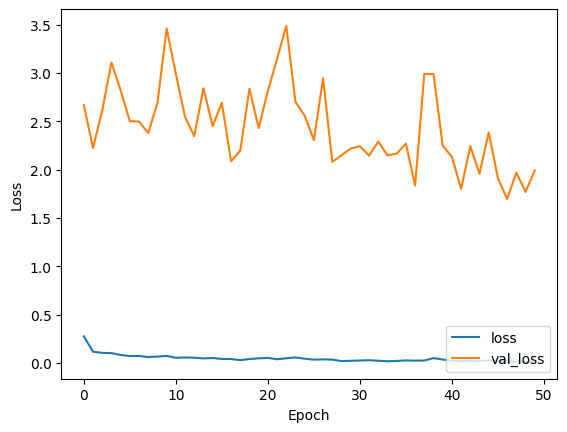

Accuracy: 0.6998639702796936, Loss: 1.9914753437042236
Test Accuracy: 0.7295


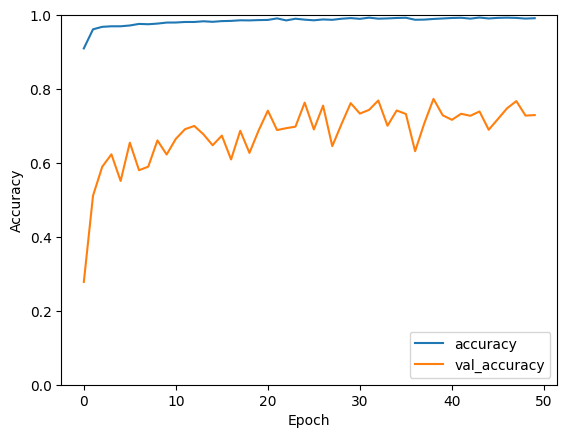

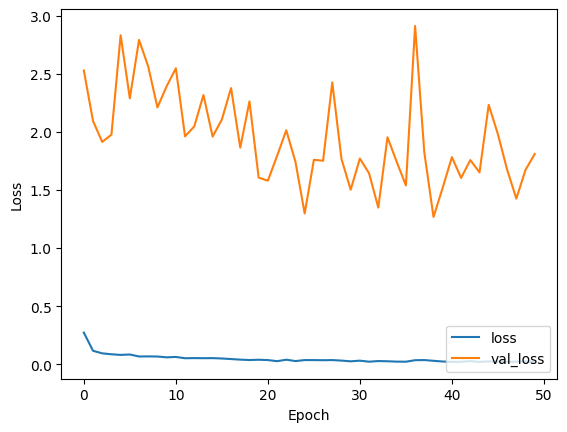

Accuracy: 0.7295238375663757, Loss: 1.8095344305038452


In [116]:
# test the mlp model with validation data
# use grid search to find the best hyperparameters
best_model = None
best_accuracy = 0
best_params = None

from sklearn.model_selection import ParameterGrid

param_grid = {
    "epochs": [30, 50],
    "batch_size": [32, 64, 128],
    "learning_rate": [0.01, 0.005]
}

"""for params in ParameterGrid(param_grid):
    model, history, test_acc, test_loss = train_model(X_train, y_train, X_val, y_val, X_train.shape[1])
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        best_model = model
        best_params = params"""

# do cross validation with all possible hyperparameters

kf = KFold(n_splits=5, shuffle=True)

fold_accuracy = []
for params in ParameterGrid(param_grid):
    print(params)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model, history, test_acc, test_loss = train_model(X_train, y_train, X_val, y_val, X.shape[1], **params)
        fold_accuracy.append(test_acc)
        if test_acc > best_accuracy:
            best_accuracy = test_acc
            best_model = model
            best_params = params
        print(f"Accuracy: {test_acc}, Loss: {test_loss}")

        





In [91]:
best_model.summary()

Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_532 (Dense)               │ (None, 64)             │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_322         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_533 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_323         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_286 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_534 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_324         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_535 (Dense)               │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_325         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_287 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_536 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_326         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_537 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_327         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_288 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_538 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_328         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_539 (Dense)               │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,066,897 (4.07 MB)

 Trainable params: 354,693 (1.35 MB)

 Non-trainable params: 2,816 (11.00 KB)

 Optimizer params: 709,388 (2.71 MB)

# aaaaa

In [31]:
import torch
import math
import csv


def calculate_angle(p1, p2, p3):
    # Create vectors
    v1 = p1 - p2
    v2 = p3 - p2
    
    # Calculate dot product and magnitudes
    dot_product = torch.dot(v1, v2)
    magnitude_v1 = torch.norm(v1)
    magnitude_v2 = torch.norm(v2)
    
    # Prevent division by zero
    if magnitude_v1 == 0 or magnitude_v2 == 0:
        return None  # Undefined angle
    
    # Calculate angle in radians
    angle_rad = torch.acos(dot_product / (magnitude_v1 * magnitude_v2))
    # Convert to degrees
    return math.degrees(angle_rad.item())

# Function to calculate Euclidean distance between two points (p1, p2)
def calculate_distance(p1, p2):
    return torch.norm(p1 - p2).item()


In [32]:
def is_standing(dataset, threshold=130):
    p1 = torch.tensor([dataset['Left Hip_position_x'], dataset['Left Hip_position_y']])
    p2 = torch.tensor([dataset['Left Knee_position_x'], dataset['Left Knee_position_y']])
    p3 = torch.tensor([dataset['Left Ankle_position_x'], dataset['Left Ankle_position_y']])
    angle = calculate_angle(p1, p2, p3)
    if angle is None:
        return None
    return angle > threshold

def is_elbow_straight(dataset, threshold=160):
    p1 = torch.tensor([dataset['Left Shoulder_position_x'], dataset['Left Shoulder_position_y']])
    p2 = torch.tensor([dataset['Left Elbow_position_x'], dataset['Left Elbow_position_y']])
    p3 = torch.tensor([dataset['Left Wrist_position_x'], dataset['Left Wrist_position_y']])
    angle = calculate_angle(p1, p2, p3)
    if angle is None:
        return None
    return angle > threshold

def is_elbow_ninety(dataset, threshold1= 60 , threshold2 = 120):
    p1 = torch.tensor([dataset['Left Shoulder_position_x'], dataset['Left Shoulder_position_y']])
    p2 = torch.tensor([dataset['Left Elbow_position_x'], dataset['Left Elbow_position_y']])
    p3 = torch.tensor([dataset['Left Wrist_position_x'], dataset['Left Wrist_position_y']])
    angle = calculate_angle(p1, p2, p3)
    if angle is None:
        return None
    return angle > threshold1 and angle < threshold2


def is_shoulder_air(dataset, threshold=160):
    p1 = torch.tensor([dataset['Left Hip_position_x'], dataset['Left Hip_position_y']])
    p2 = torch.tensor([dataset['Left Shoulder_position_x'], dataset['Left Shoulder_position_y']])
    p3 = torch.tensor([dataset['Left Elbow_position_x'], dataset['Left Elbow_position_y']])
    angle = calculate_angle(p1, p2, p3)
    if angle is None:
        return None
    return angle > threshold

def is_shoulder_adjoining(dataset, threshold=30):
    p1 = torch.tensor([dataset['Left Hip_position_x'], dataset['Left Hip_position_y']])
    p2 = torch.tensor([dataset['Left Shoulder_position_x'], dataset['Left Shoulder_position_y']])
    p3 = torch.tensor([dataset['Left Elbow_position_x'], dataset['Left Elbow_position_y']])
    angle = calculate_angle(p1, p2, p3)
    if angle is None:
        return None
    return angle < threshold


In [97]:
from ultralytics import YOLO
import torch
import math
import csv
import pandas as pd
import joblib
import pandas as pd
import os 
import numpy as np

def preprocess_image(image_path):

    model = YOLO("yolo11x-pose.pt")

    model.to('cuda')        
    results = model.predict(image_path, imgsz=320, conf=0.5)

    # List to store calculated angles and distances for each image
    angles_per_image = []

    # Define joint triplets for angle calculations
    joint_triplets = [
        (5, 7, 9),  # Left Elbow
        (6, 8, 10), # Right Elbow
        (5, 11, 13),# Left Hip
        (6, 12, 14),# Right Hip
        (7, 5, 11), # Left Shoulder
        (8, 6, 12), # Right Shoulder
        (11, 13, 15),# Left Knee
        (12, 14, 16) # Right Knee
    ]

    # Joint labels for reference
    joint_labels = ["Nose", "Left Eye", "Right Eye", "Left Ear", "Right Ear",
                "Left Shoulder", "Right Shoulder", "Left Elbow", "Right Elbow",
                "Left Wrist", "Right Wrist", "Left Hip", "Right Hip",
                "Left Knee", "Right Knee", "Left Ankle", "Right Ankle"]
    # Iterate over each image in the batch

    for img_idx in range(len(results)):  # Iterate over images (batch size)
        if len(results[img_idx]) == 0:
            print(f"No keypoints detected in image {img_idx + 1}")
            continue
        if len(results[img_idx]) > 1:
            print(f"Multiple detections in image {img_idx + 1}")
            continue
        image_angles = {"Image": img_idx + 1}
        
        # Calculate angles and distances for each joint triplet
        for triplet in joint_triplets:
            p1 = results[img_idx].keypoints.xy[0][triplet[0]]  # Correctly access the joint coordinates
            p2 = results[img_idx].keypoints.xy[0][triplet[1]]
            p3 = results[img_idx].keypoints.xy[0][triplet[2]]
            
            # Make sure the coordinates are tensors and have the shape [2] (x, y)
            angle = calculate_angle(p1, p2, p3)
            image_angles[f"{joint_labels[triplet[0]]}-{joint_labels[triplet[1]]}-{joint_labels[triplet[2]]}"] = angle
        
        # Calculate and add distances for each joint pair
        for i in range(len(results[img_idx].keypoints.xy[0])):
            for j in range(i + 1, len(results[img_idx].keypoints.xy[0])):
                p1 = results[img_idx].keypoints.xy[0][i]
                p2 = results[img_idx].keypoints.xy[0][j]
                distance = calculate_distance(p1, p2)
                image_angles[f"{joint_labels[i]}-{joint_labels[j]}_distance"] = distance

        #add the positions of the joints
        for i in range(len(results[img_idx].keypoints.xy[0])):
            p1 = results[img_idx].keypoints.xy[0][i]
            y_pos = p1[1]
            # convert tensor to float
            y_pos = y_pos.item()

            x_pos = p1[0]
            # convert tensor to float
            x_pos = x_pos.item()

            image_angles[f"{joint_labels[i]}_position_y"] = y_pos
            image_angles[f"{joint_labels[i]}_position_x"] = x_pos
            
        
        angles_per_image.append(image_angles)

    # return angles_per_image as a dataframe
    df = pd.DataFrame(angles_per_image)
    dropped_columns = ['Left Shoulder-Left Elbow-Left Wrist',
    'Right Shoulder-Right Elbow-Right Wrist',
    'Left Shoulder-Left Hip-Left Knee',
    'Right Shoulder-Right Hip-Right Knee',
    'Left Elbow-Left Shoulder-Left Hip',
    'Right Elbow-Right Shoulder-Right Hip', 'Left Hip-Left Knee-Left Ankle',
    'Right Hip-Right Knee-Right Ankle', 'Image']
    df = df.drop(columns = dropped_columns)


    hand_crafted_features = pd.DataFrame()

    hand_crafted_features["is_standing"] = df.apply(is_standing, axis=1)
    
    hand_crafted_features["is_elbow_straight"] = df.apply(is_elbow_straight, axis=1)

    hand_crafted_features["is_elbow_ninety"] = df.apply(is_elbow_ninety, axis=1)

    hand_crafted_features["is_shoulder_air"] = df.apply(is_shoulder_air, axis=1)

    hand_crafted_features["is_shoulder_adjoining"] = df.apply(is_shoulder_adjoining, axis=1)


    for column in hand_crafted_features.columns:
        hand_crafted_features[column] = hand_crafted_features[column].apply(lambda x: 0.5 if x is None else 0 if x == False else 1)

    added_joints = ["Left Shoulder", "Right Shoulder", "Left Elbow", "Right Elbow","Left Wrist", "Right Wrist", "Left Hip", "Right Hip",
            "Left Knee", "Right Knee", "Left Ankle", "Right Ankle"]

    # put these positions and distances between them to a hand_crafted_features dataframe
    for joint in added_joints:
        hand_crafted_features[f"{joint}_position_x"] = df[f"{joint}_position_x"]
        hand_crafted_features[f"{joint}_position_y"] = df[f"{joint}_position_y"]

    # put distances between each joint to the dataframe
    for i in range(len(added_joints)):
        for j in range(i + 1, len(added_joints)):
            hand_crafted_features[f"{added_joints[i]}-{added_joints[j]}_distance"] = df[f"{added_joints[i]}-{added_joints[j]}_distance"]

    # scale data using standard scaler saved in models folder
    standardScaler = joblib.load("models/standard_scaler.joblib")
    hand_crafted_features = standardScaler.transform(hand_crafted_features)
    print(hand_crafted_features)
    return hand_crafted_features
    

In [98]:
def predict(image_folder, model_path, encoder_path):
    # Load the model
    model = joblib.load(model_path)
    encoder = joblib.load(encoder_path)

    # Load the image
    image_angles = preprocess_image(image_folder)
    if image_angles is None:
        return None

    # Make predictions
    predictions = model.predict(image_angles)
    print(predictions)
    if predictions is None:
        return None
    # decode the predictions with using the encoder
    predictions = predictions.argmax(axis=1)
    predictions = encoder.inverse_transform(predictions)
    return predictions


In [118]:
# make prediction on the validation dataset
def test_model(dataset_path,model_path,encoder_path):
    y_pred = None
    y_test = None
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        
        predictions = predict(folder_path, model_path, encoder_path)
        if predictions is None:
            continue
        # create numpy array that holds real values of the image with folder name
        # y_test = np.array(folder name) * len(predictions)
        y_test = np.concatenate((y_test, [folder] * len(predictions)), axis=0) if y_test is not None else [folder] * len(predictions)
        y_pred = np.concatenate((y_pred, predictions), axis=0) if y_pred is not None else predictions
        print(f"Predicted: {predictions} for image {folder}")

    return y_test, y_pred

            
            

In [119]:
y_test, y_pred = test_model("validation_dataset", "models/best_mlp_model.joblib", "models/label_encoder.joblib")


image 1/818 c:\Users\Samet\Desktop\3. Grade 1. Term\AIN 311 - 313\project\yolo model\validation_dataset\bench press\0.00000258.jpg: 320x192 1 person, 69.7ms
image 2/818 c:\Users\Samet\Desktop\3. Grade 1. Term\AIN 311 - 313\project\yolo model\validation_dataset\bench press\0.00226286.jpg: 320x192 (no detections), 31.7ms
image 3/818 c:\Users\Samet\Desktop\3. Grade 1. Term\AIN 311 - 313\project\yolo model\validation_dataset\bench press\0.00241480.jpg: 320x192 (no detections), 39.3ms
image 4/818 c:\Users\Samet\Desktop\3. Grade 1. Term\AIN 311 - 313\project\yolo model\validation_dataset\bench press\0.00377820.jpg: 320x192 1 person, 28.6ms
image 5/818 c:\Users\Samet\Desktop\3. Grade 1. Term\AIN 311 - 313\project\yolo model\validation_dataset\bench press\0.00454068.jpg: 320x192 1 person, 29.7ms
image 6/818 c:\Users\Samet\Desktop\3. Grade 1. Term\AIN 311 - 313\project\yolo model\validation_dataset\bench press\0.00630258.jpg: 320x192 1 person, 28.6ms
image 7/818 c:\Users\Samet\Desktop\3. Grade

In [120]:
# print classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 bench press       0.78      0.80      0.79       721
 hammer curl       0.95      0.94      0.95       779
lat pulldown       0.72      0.81      0.76       575
       plank       0.49      0.68      0.57       711
     push up       0.78      0.45      0.57       847

    accuracy                           0.73      3633
   macro avg       0.74      0.74      0.73      3633
weighted avg       0.75      0.73      0.73      3633



In [3]:
import joblib
import pandas as pd

# Load the model
model = joblib.load("models/best_mlp_model.joblib")
# learn the paramters of the model #


AttributeError: 'Sequential' object has no attribute 'get_params'